In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

from scipy.stats import ttest_1samp, uniform, randint, ttest_ind
from scipy import stats
from statsmodels.stats import weightstats as stests

In [3]:
%run CoreFunction.ipynb

In [4]:
plt.style.use('seaborn')

In [5]:
TEST_SIZE=0.15
n_comp = 0.95

In [6]:
scaler_min_max = MinMaxScaler()
scaler_z_score = StandardScaler()

# Electricity Price Forecast

## Support Vector Machine

In [7]:
def evaluate_svr(att, target, c, model_wrapper):
    svr = LinearSVR(epsilon=0.0, C=c, max_iter = 1000, tol = 0.001, random_state=42,  loss='squared_epsilon_insensitive', dual=False)
    if model_wrapper == "MultiOutputRegressor":
        svr_wrapped = MultiOutputRegressor(svr)
    elif model_wrapper == "RegressorChain":
        svr_wrapped = RegressorChain(svr)
    else: 
        return
    svr_wrapped.fit(att, target)            
    return svr_wrapped

In [8]:
@timeit
def get_model_results(PC_train, price_target_train, PC_test, price_target_test, c, model_wrapper):
    results = pd.DataFrame(columns=['C', 'mse_train', 'mae_train', 'rmse_train', 'r2_train', 'mse_test', 'mae_test', 'rmse_test', 'r2_test'])
    for i in range (0,len(c)):
        linear_SVR = evaluate_svr(PC_train, price_target_train, c[i], model_wrapper)
        mse, mae, rmse, r2 = evaluation_results(linear_SVR, PC_train, price_target_train)
        mse_test, mae_test, rmse_test, r2_test = evaluation_results(linear_SVR, PC_test, price_target_test)
        df = pd.DataFrame()
        df = {'C':c[i] , 'mse_train':mse, 'mae_train':mae, 'rmse_train':rmse, 'r2_train':r2, 'mse_test':mse_test, 'mae_test':mae_test, 'rmse_test':rmse_test, 'r2_test':r2_test}
        results = results.append(df, ignore_index = True)
    results = results.set_index('C')
    return results

## Read Price and Normalize Data

In [9]:
price_target, price_attribute, df_data_price = read_data("price actual", r"data\df_data_price_ts720_120_24.csv")

In [10]:
price_atribute_train, price_atribute_test, price_target_train, price_target_test, price_attribute_col_names = scaled_data(price_target, price_attribute, TEST_SIZE, scaler_z_score)

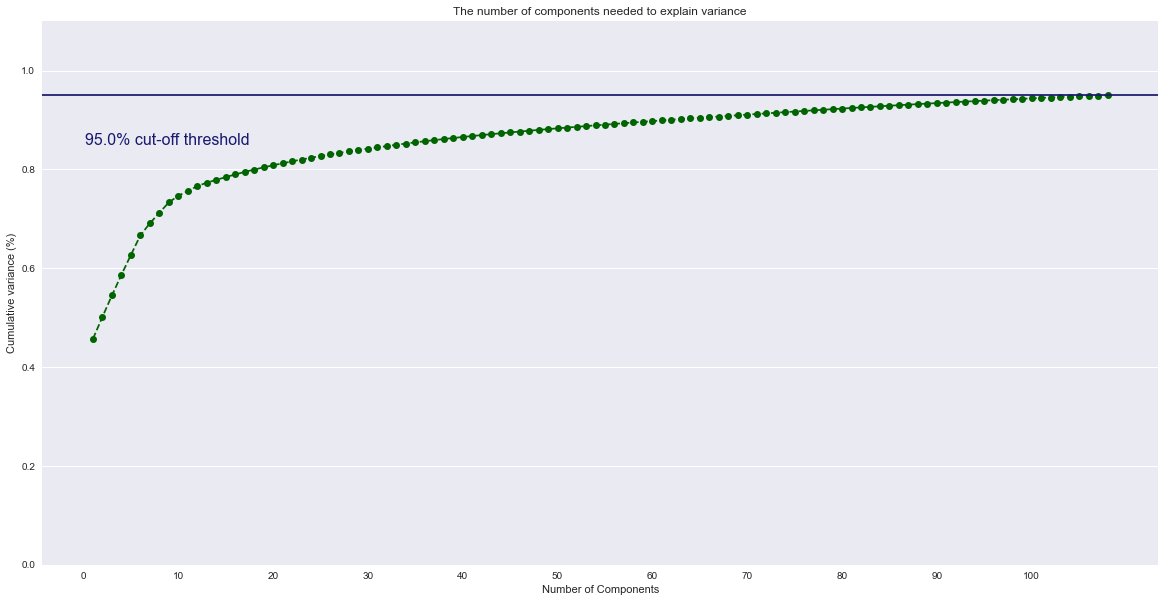

Transformed train shape: (29071, 108)
Transformed test shape: (5131, 108)
Function took 5.9136 seconds


In [11]:
most_important_features, PC_train, PC_test = PCA_feature_preprocessing(price_atribute_train, price_atribute_test, n_comp = n_comp, col_names = price_attribute.columns)

## Multi-Output Linear Support Vector Regression

Поддържаща векторна регресия (SVR)

Support Vector Machine може да се използва и като a регресионен метод, запазвайки всички основни характеристики, които характеризират алгоритъма, като:

- SVR има допълнителен регулируем параметър ε (епсилон). Стойността на епсилон определя ширината на ивицата около оценената функция (хиперравнина). Точките, които попадат в тази ивица, се считат за правилни прогнози и не се наказват от алгоритъма.
- Опорните вектори са точките, които попадат извън ивицата, а не само тези на границата.
- ξ  измерва разстоянието до точки извън ивицата и може да се контролира чрез параметър за регулиране C. 

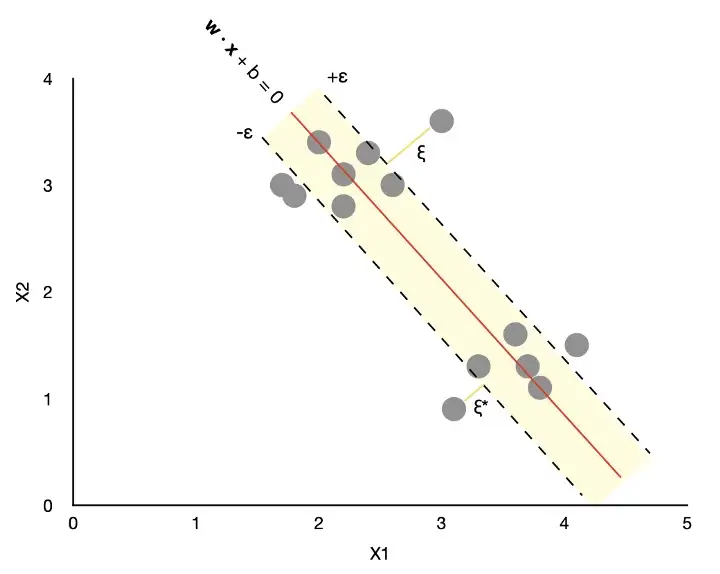

SVR е много по-гъвкав в сравнение с линейната регресия. Той може да улови промяната на наклона, докато простата линейна регресия има само един параметър на наклон. 

Множествената линейна регресия създава прогнозна равнина, която изглежда като плосък лист хартия. Междувременно SVR е по-скоро като мека тъкан, която можете да огъваме в пространството.

__Линеен SVR__

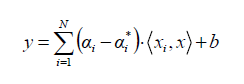


__Нелинеен SVR__

Функциите на ядрото трансформират данните в по-високо измерение функционално пространство, което да направи възможно изпълнението на линейно разделяне. 

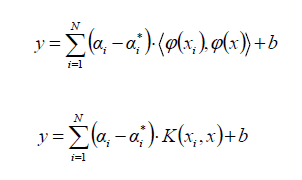



SVR не поддържа множествен изход и поради тази причина се нуждае от външни обвивки. В проекта са тествани MultiOutputRegressor и RegressorChain. 


### Test Base Model

По своята същност линейният SVR е на практика аналогичен на линейна регресия с регуляризация. Поради тази причина очакваме резултатите на SVR да са подобни на Lasso и Ridge.<br>

Първоначално тестваме модела без настройка на хиперпараметри, така че долните може да не са идеални за този модел. След опитите за оптимизация резултата не е особено подобрен. Обучението е много бавно. 

In [13]:
@timeit
def linear_svr(att, target):
    svr = LinearSVR(C=1.0, max_iter=10000, tol=0.0001, random_state=42)
    svr_wrapped = MultiOutputRegressor(svr, n_jobs=None)
    svr_wrapped.fit(att, target)            
    return svr_wrapped

price_linear_SVR = linear_svr(PC_train, price_target_train)

C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.p

Function took 5107.3829 seconds


In [12]:
save_model(price_linear_SVR, "#price_linear_SVR_base_pca.sav")

In [12]:
price_linear_SVR = load_model("#price_linear_SVR_base_pca.sav")

In [13]:
_, _, _ = evaluation_report(price_linear_SVR, PC_train, price_target_train)

Score Results:
Mean squared error: 53.66
Root mean squared error: 7.32
Mean absolute error: 5.28
Coefficient of determination: 0.7320
Predicted mean: 58.276 (12.282)


In [14]:
_, _, _ = evaluation_report(price_linear_SVR, PC_test, price_target_test)

Score Results:
Mean squared error: 53.15
Root mean squared error: 7.29
Mean absolute error: 5.28
Coefficient of determination: 0.7267
Predicted mean: 58.239 (12.161)


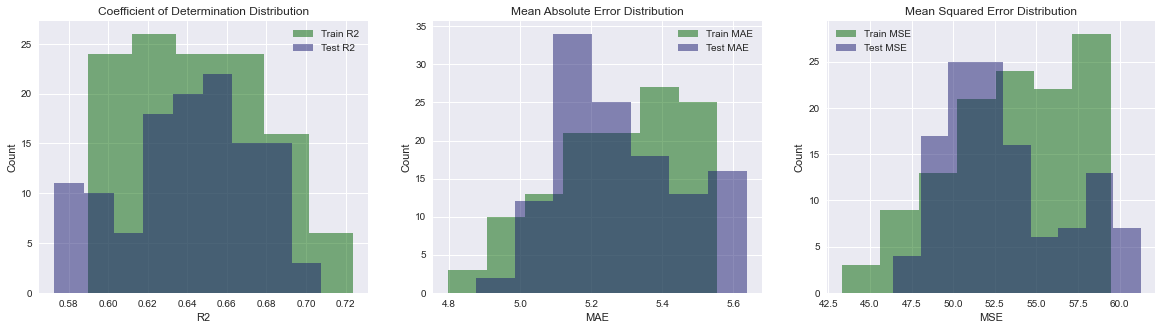

In [15]:
r2_train, r2_test, mae_train, mae_test, mse_train, mse_test = generate_score_distributions(price_linear_SVR, PC_train, price_target_train, PC_test, price_target_test )

In [16]:
pv_r2_ttest = get_ttest_2samples(r2_train, r2_test)
pv_mae_ttest = get_ttest_2samples(mae_train, mae_test)
pv_mse_ttest = get_ttest_2samples(mse_train, mse_test)

p-value: 0.3943287105725104
fail to reject the null hypothesis
p-value: 0.8863947513059368
fail to reject the null hypothesis
p-value: 0.2976633608281403
fail to reject the null hypothesis


In [17]:
pv_r2_ztest = get_ztest_2samples(r2_train, r2_test)
pv_mae_ztest = get_ztest_2samples(mae_train, mae_test)
pv_mse_ztest = get_ztest_2samples(mse_train, mse_test)

p-value: 0.3934707109949832
fail to reject the null hypothesis
p-value: 0.8862737411369336
fail to reject the null hypothesis
p-value: 0.2966043779069528
fail to reject the null hypothesis


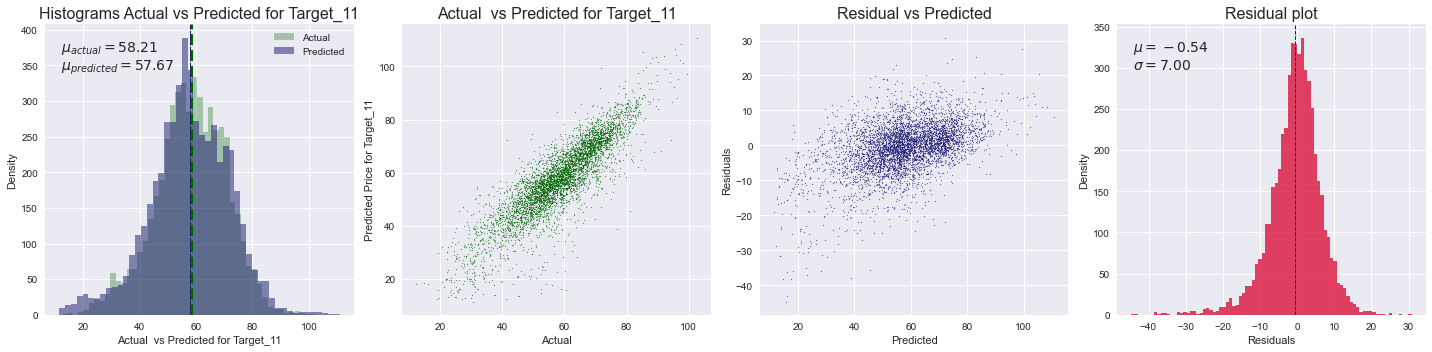

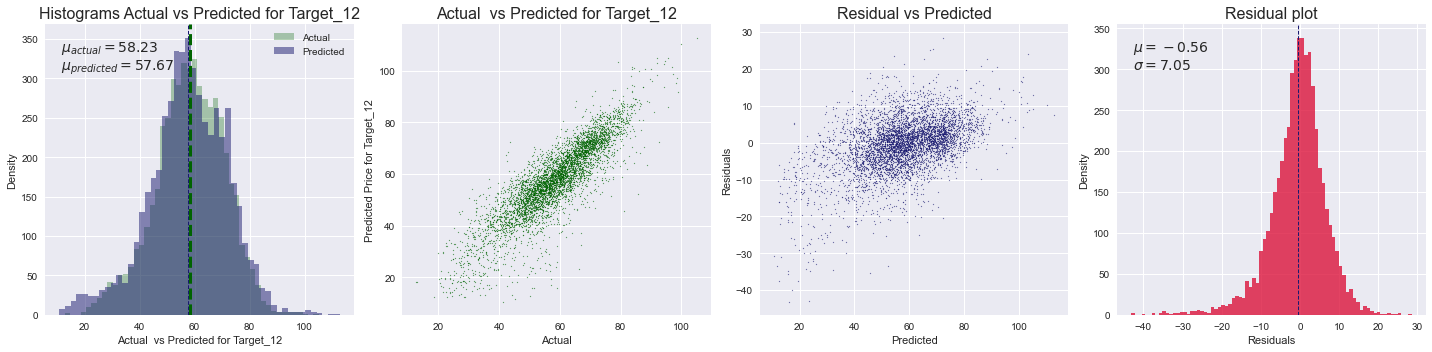

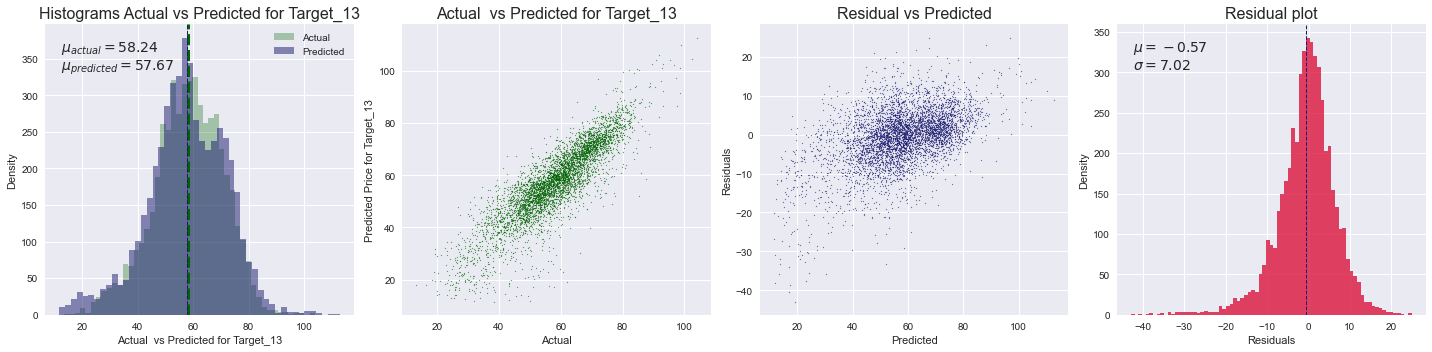

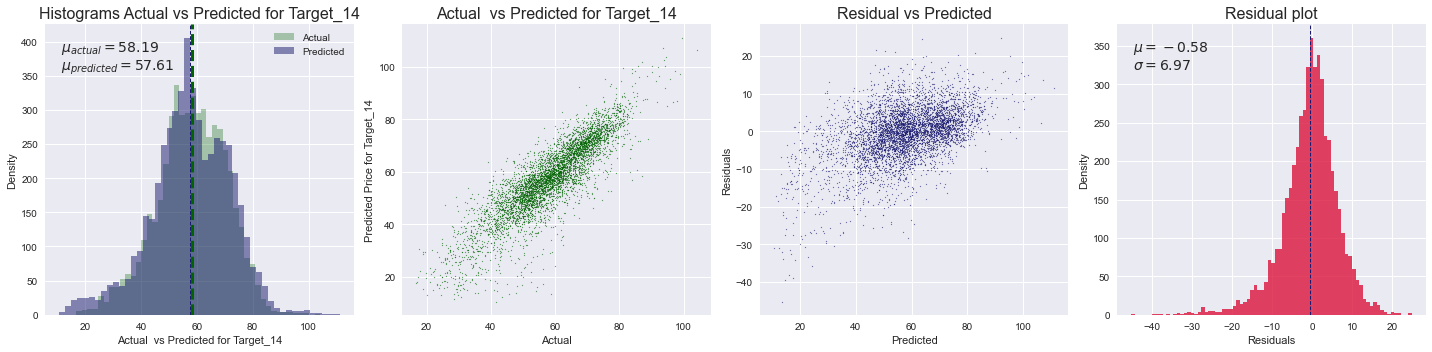

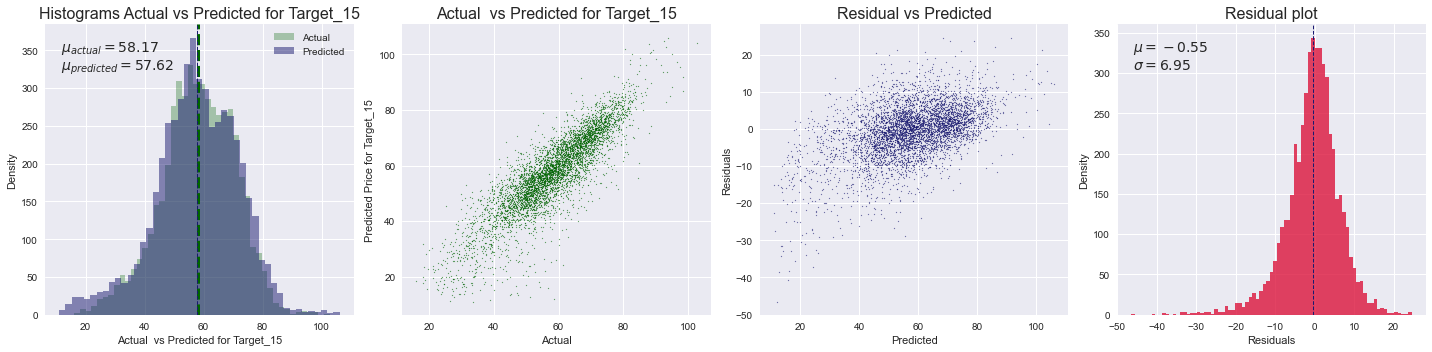

In [18]:
price_prediction = price_linear_SVR.predict(PC_test)
e_minus_o = get_and_plot_data(price_prediction, price_target_test, start_index=10, stop_index=15)

In [19]:
print(get_ttest (price_prediction, price_target_test, idx=101))

p-value: 5.251313786771479e-07
we are rejecting null hypothesis


In [20]:
print(get_ztest (price_prediction, price_target_test, idx=101))

p-value: 5.079096151683988e-07
reject null hypothesis


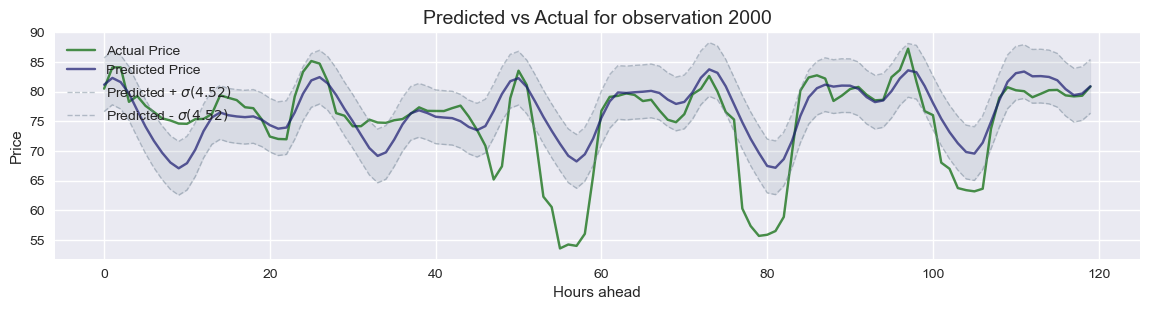

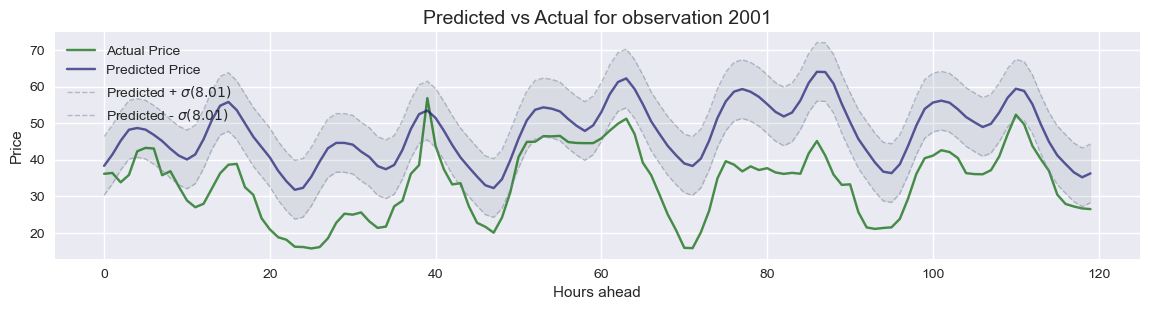

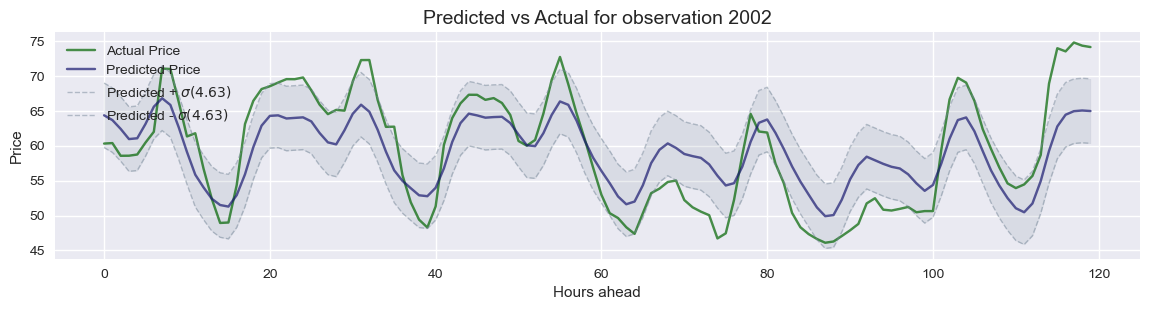

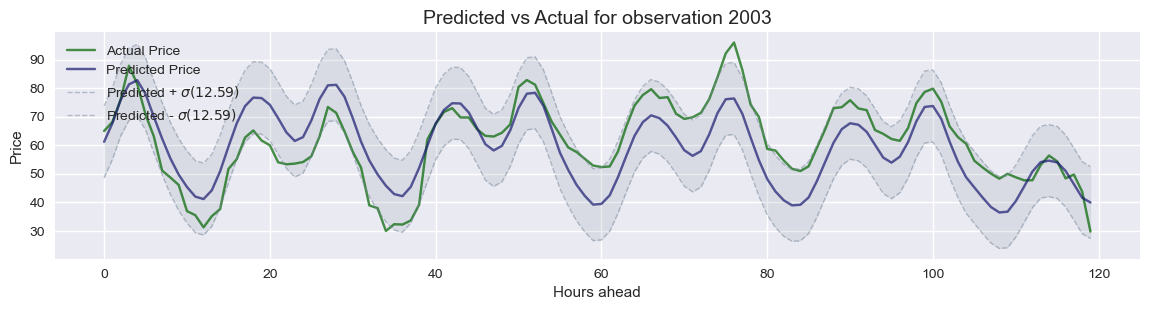

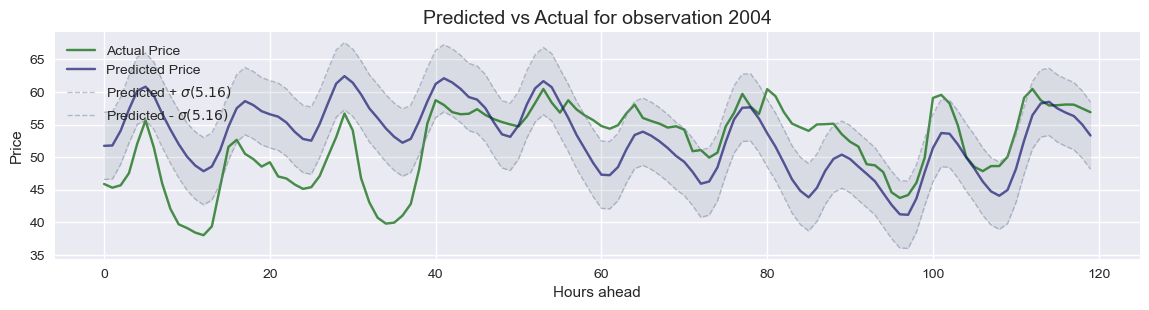

In [21]:
plot_actual_vs_prediction(price_prediction, price_target_test, variable_name = 'Price', start_inx = 2000, end_inx = 2005)

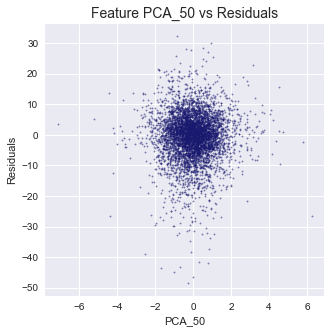

In [19]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=50, stop_index=51, target_indx = 119, col_name = None) 

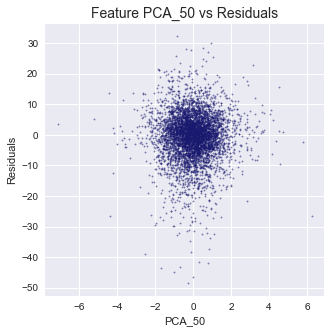

In [20]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=45, stop_index=52, target_indx = 119, col_name = 'PCA_50') 

### Multi-Output Linear Support Vector Regression Optimisation

In [11]:
svr = LinearSVR(random_state=42)
linear_svr = MultiOutputRegressor(svr)

tuned_params = {
    'estimator__C': [0.1, 10],
    'estimator__max_iter':[10000],
    'estimator__tol': [0.0001],
}
cv = 3

price_svr_pca = get_grid_search(linear_svr, tuned_params, cv, PC_train, price_target_train )

MultiOutputRegressor(estimator=LinearSVR(C=0.1, max_iter=10000,
                                         random_state=42))
Function took 11095.0590 seconds


In [20]:
save_model(price_svr_pca, "#price_svr_pca.sav")

In [21]:
price_svr_pca = load_model("#price_svr_pca.sav")
price_svr_pca = price_svr_pca.best_estimator_

In [22]:
_, _, _ = evaluation_report(price_svr_pca, PC_train, price_target_train)

Score Results:
Mean squared error: 53.52
Root mean squared error: 7.31
Mean absolute error: 5.28
Coefficient of determination: 0.7328
Predicted mean: 58.138 (12.298)


In [23]:
_, _, _ = evaluation_report(price_svr_pca, PC_test, price_target_test)

Score Results:
Mean squared error: 53.02
Root mean squared error: 7.28
Mean absolute error: 5.28
Coefficient of determination: 0.7274
Predicted mean: 58.102 (12.176)


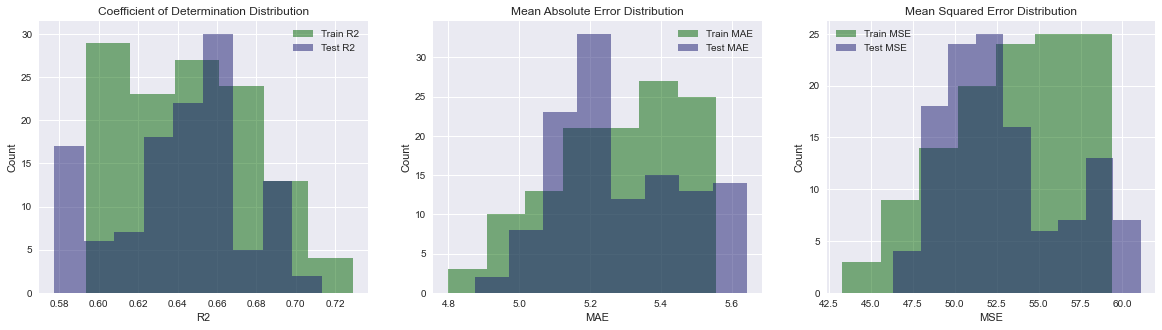

In [24]:
r2_train, r2_test, mae_train, mae_test, mse_train, mse_test = generate_score_distributions(price_svr_pca, PC_train, price_target_train, PC_test, price_target_test )

In [28]:
pv_r2_ttest = get_ttest_2samples(r2_train, r2_test)
pv_mae_ttest = get_ttest_2samples(mae_train, mae_test)
pv_mse_ttest = get_ttest_2samples(mse_train, mse_test)

p-value: 0.3801783778364731
fail to reject the null hypothesis
p-value: 0.9418635340304997
fail to reject the null hypothesis
p-value: 0.3195517528335835
fail to reject the null hypothesis


In [29]:
pv_r2_ztest = get_ztest_2samples(r2_train, r2_test)
pv_mae_ztest = get_ztest_2samples(mae_train, mae_test)
pv_mse_ztest = get_ztest_2samples(mse_train, mse_test)

p-value: 0.37929156747824055
fail to reject the null hypothesis
p-value: 0.9418022177016253
fail to reject the null hypothesis
p-value: 0.31853871355079444
fail to reject the null hypothesis


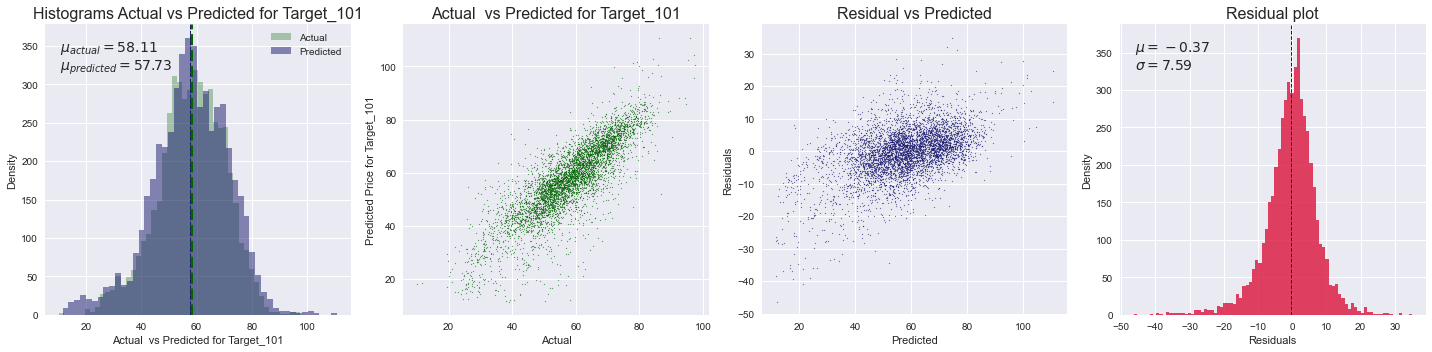

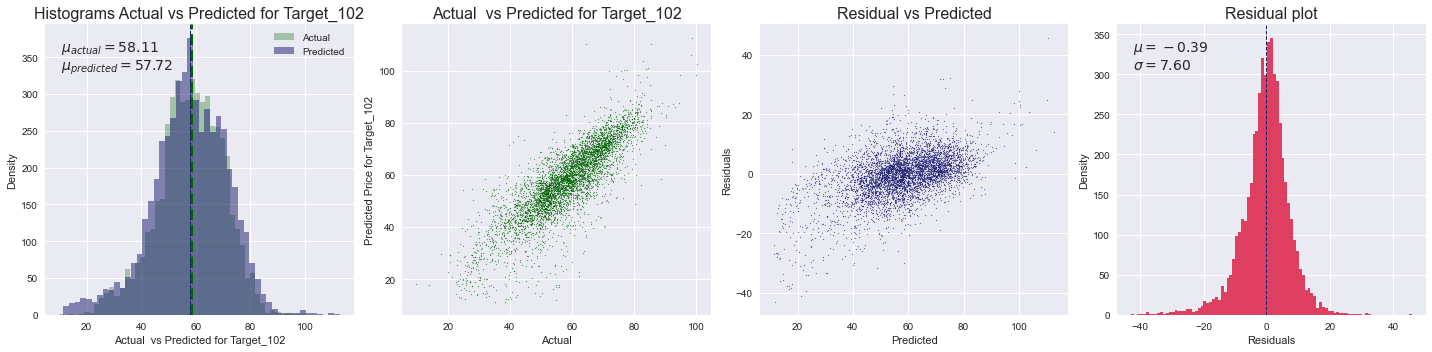

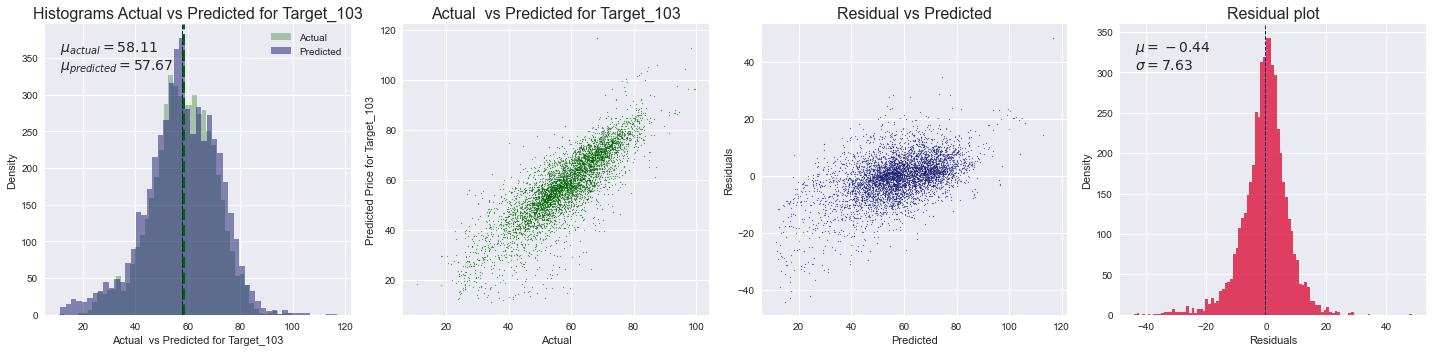

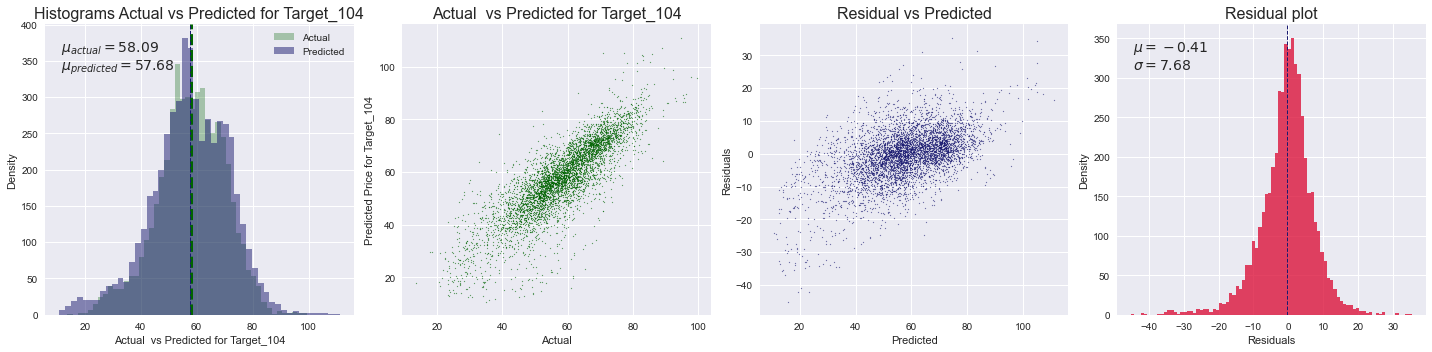

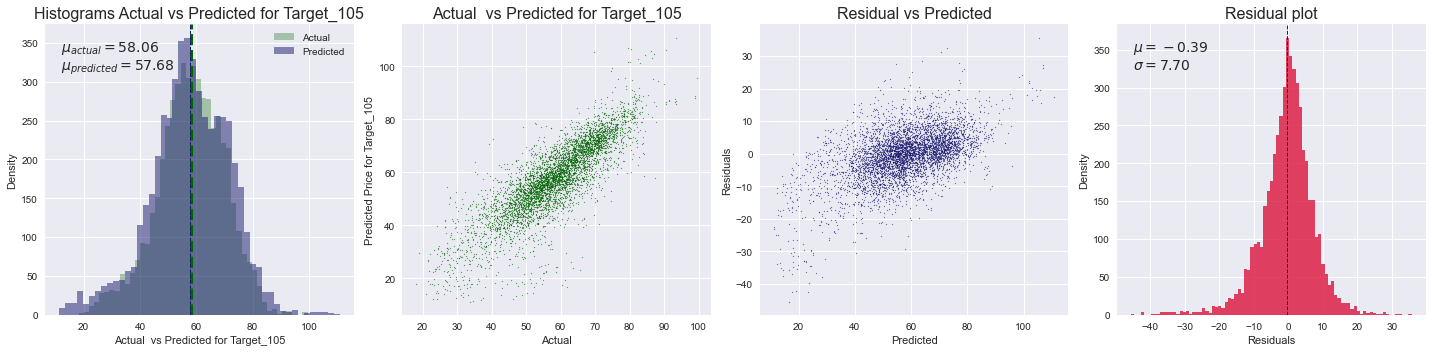

In [25]:
price_prediction = price_svr_pca.predict(PC_test)
e_minus_o = get_and_plot_data(price_prediction, price_target_test, start_index=100, stop_index=105)

In [31]:
print(get_ttest (price_prediction, price_target_test, idx=101))

p-value: 0.00022965509852942179
we are rejecting null hypothesis


In [32]:
print(get_ztest (price_prediction, price_target_test, idx=101))

p-value: 0.000227306744421137
reject null hypothesis


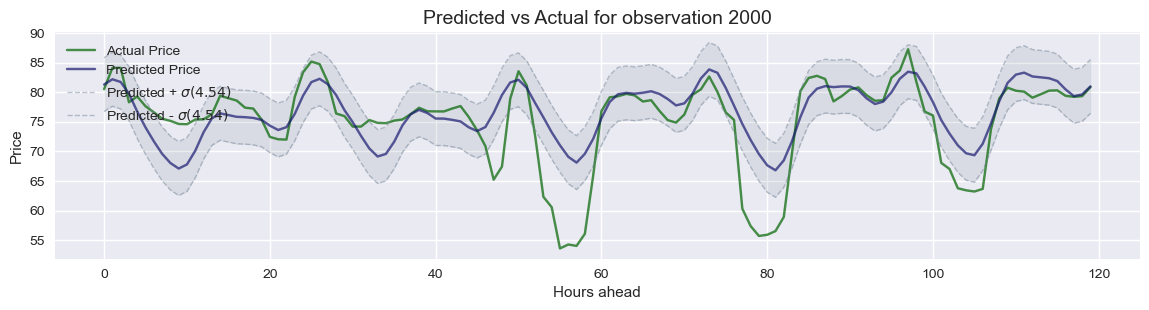

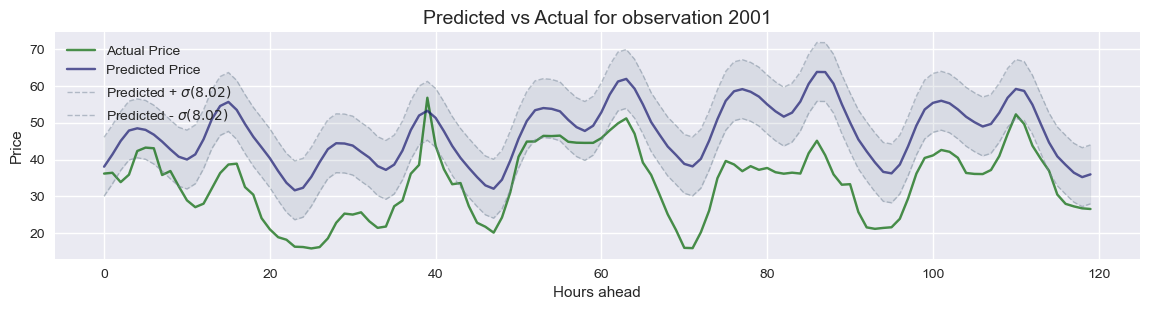

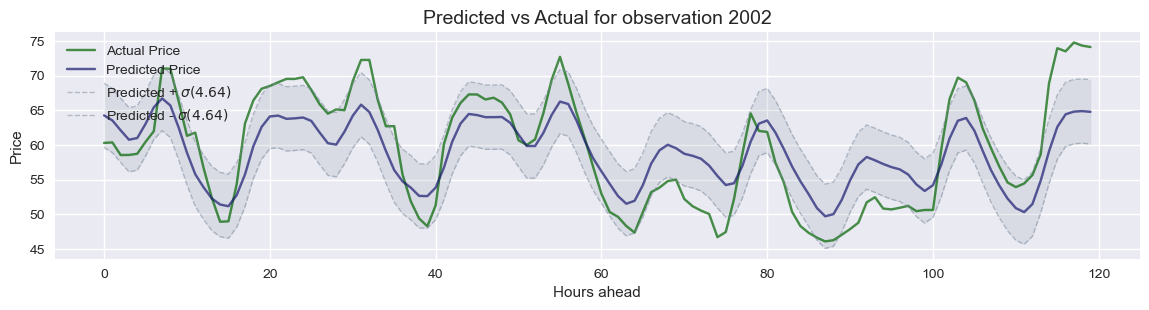

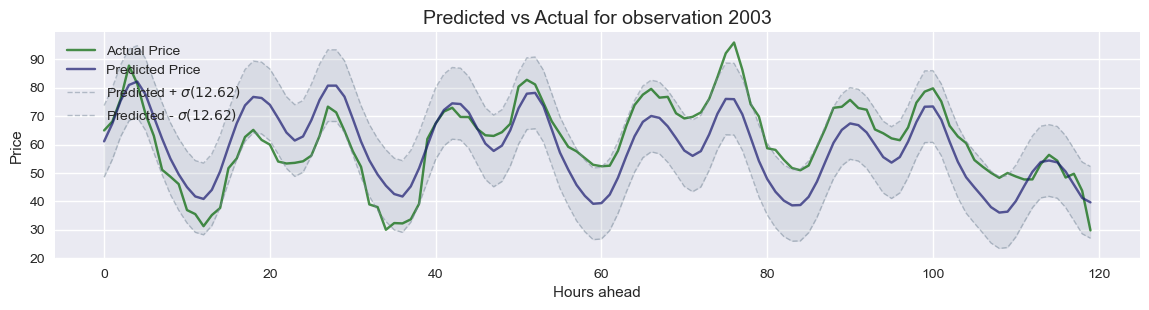

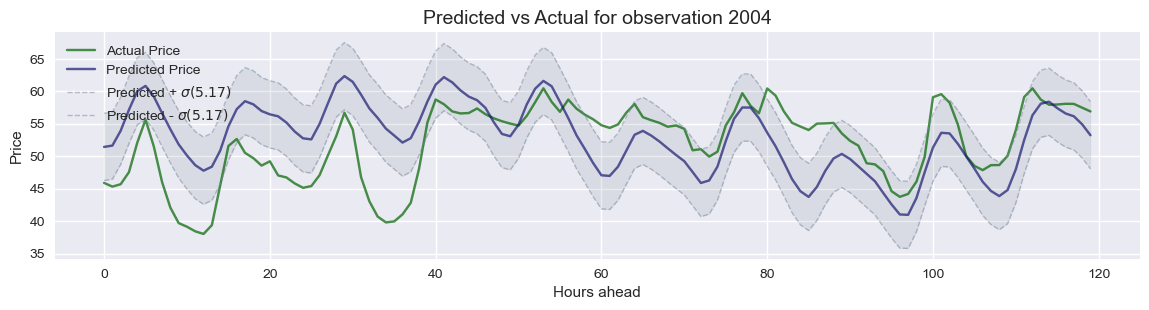

In [33]:
plot_actual_vs_prediction(price_prediction, price_target_test, variable_name = 'Price', start_inx = 2000, end_inx = 2005)

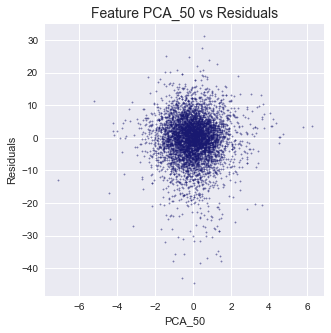

In [26]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=50, stop_index=51, target_indx = 10, col_name = None) 

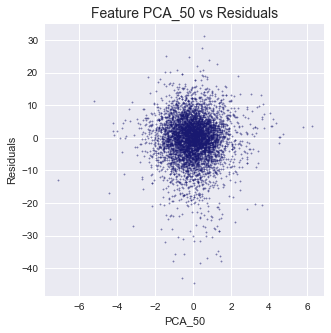

In [28]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=45, stop_index=52, target_indx = 10, col_name = 'PCA_50') 

In [11]:
svr = LinearSVR(random_state=42 )
linear_svr = MultiOutputRegressor(svr)

tuned_params = {
    'estimator__C': [0.001,0.01],
    'estimator__max_iter':[1000],
    'estimator__tol': [0.001],
}
cv = 3

price_svr_gs = get_grid_search(linear_svr, tuned_params, cv, price_atribute_train, price_target_train)

MultiOutputRegressor(estimator=LinearSVR(C=0.01, random_state=42, tol=0.001))
Function took 478.8254 seconds


In [12]:
save_model(price_svr_gs, "#price_svr_gs_oplimal.sav")

In [36]:
price_svr_gs = load_model("#price_svr_gs_oplimal.sav")
price_svr_gs = price_svr_gs.best_estimator_

In [37]:
_, _, _ = evaluation_report(price_svr_gs, price_atribute_train, price_target_train)

Score Results:
Mean squared error: 51.80
Root mean squared error: 7.19
Mean absolute error: 5.24
Coefficient of determination: 0.7413
Predicted mean: 56.771 (12.574)


In [38]:
_, _, _ = evaluation_report(price_svr_gs, price_atribute_test, price_target_test)

Score Results:
Mean squared error: 52.40
Root mean squared error: 7.23
Mean absolute error: 5.34
Coefficient of determination: 0.7305
Predicted mean: 56.709 (12.458)


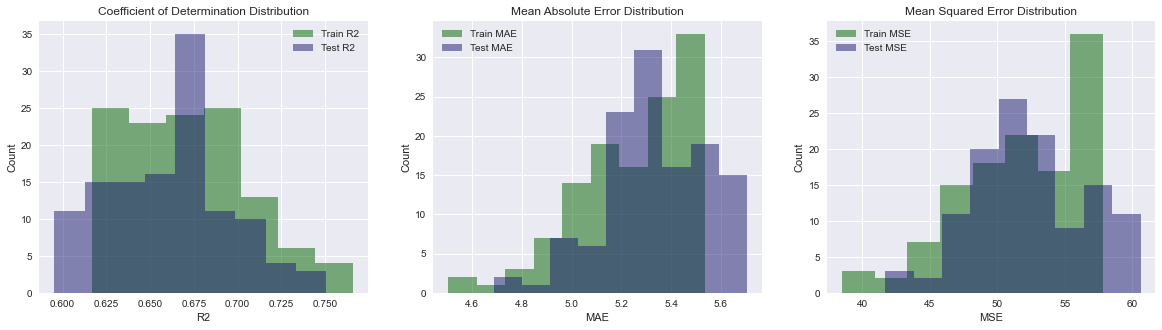

In [39]:
r2_train, r2_test, mae_train, mae_test, mse_train, mse_test = generate_score_distributions(price_svr_gs, price_atribute_train, price_target_train, price_atribute_test, price_target_test )

In [40]:
pv_r2_ttest = get_ttest_2samples(r2_train, r2_test)
pv_mae_ttest = get_ttest_2samples(mae_train, mae_test)
pv_mse_ttest = get_ttest_2samples(mse_train, mse_test)

p-value: 0.02216071011493864
we are rejecting null hypothesis
p-value: 0.000817346825898599
we are rejecting null hypothesis
p-value: 0.2779428487717638
fail to reject the null hypothesis


In [41]:
pv_r2_ztest = get_ztest_2samples(r2_train, r2_test)
pv_mae_ztest = get_ztest_2samples(mae_train, mae_test)
pv_mse_ztest = get_ztest_2samples(mse_train, mse_test)

p-value: 0.021297171274203545
reject null hypothesis
p-value: 0.0006982877410232755
reject null hypothesis
p-value: 0.27684281481293793
fail to reject the null hypothesis


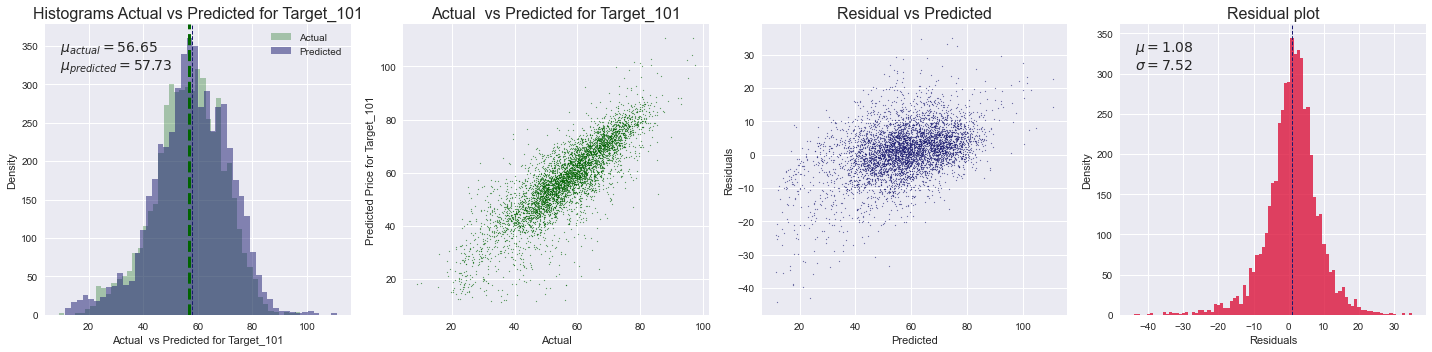

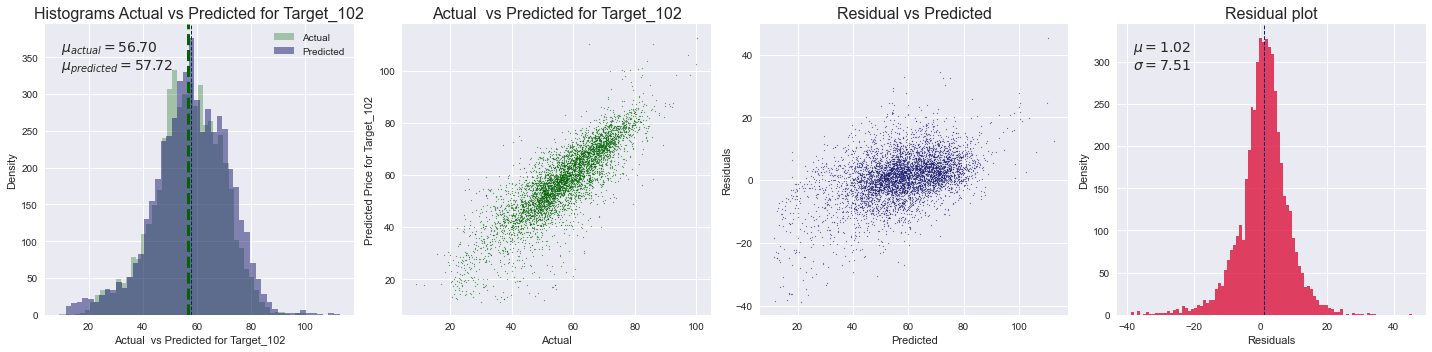

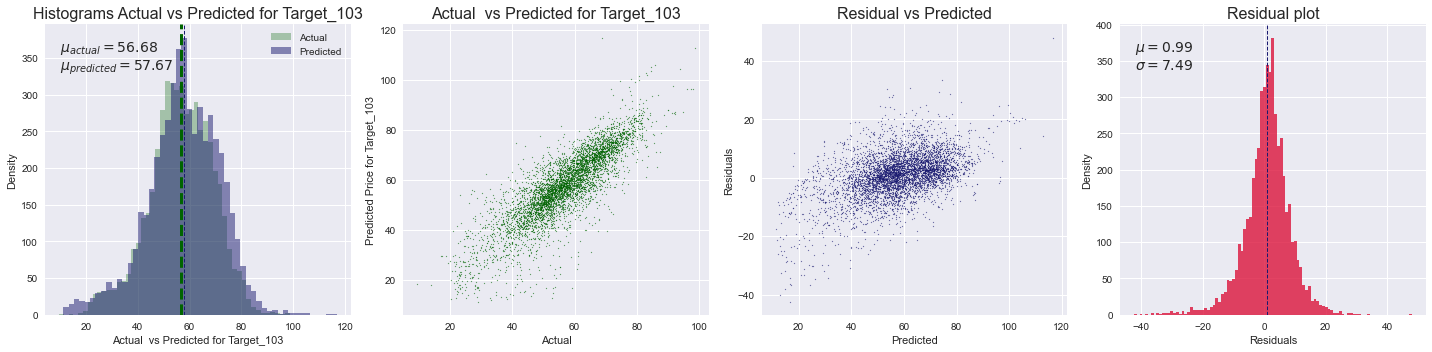

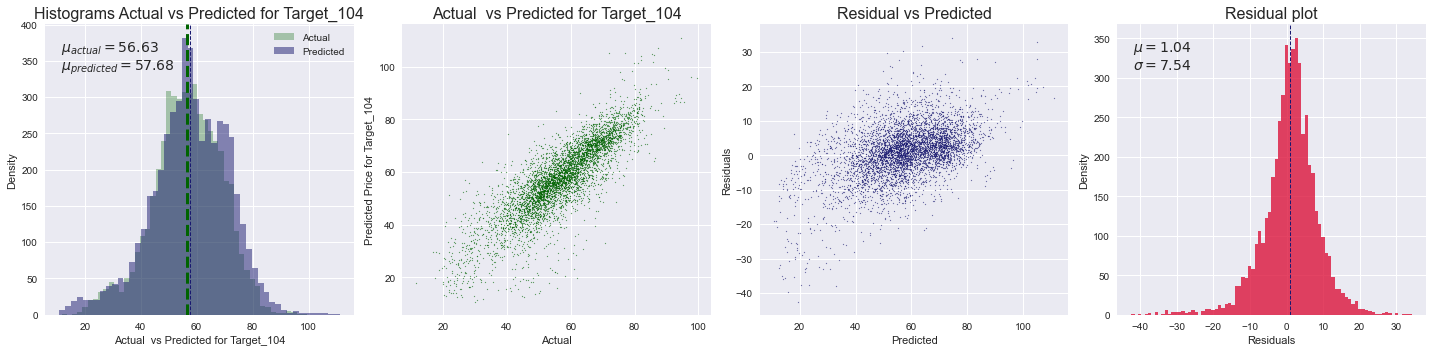

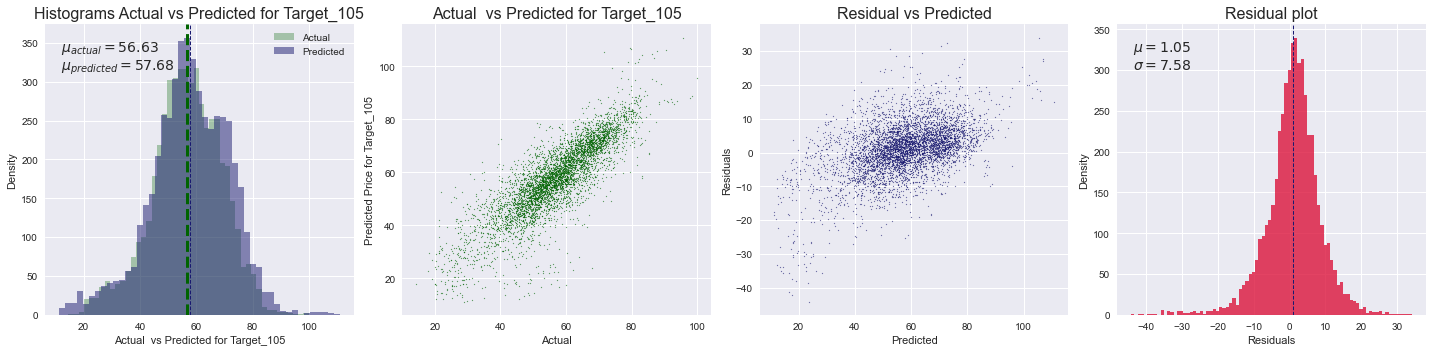

In [42]:
price_prediction = price_svr_gs.predict(price_atribute_test)
e_minus_o = get_and_plot_data(price_prediction, price_target_test, start_index=100, stop_index=105)

In [43]:
print(get_ttest (price_prediction, price_target_test, idx=101))

p-value: 4.297961359387227e-22
we are rejecting null hypothesis


In [44]:
print(get_ztest (price_prediction, price_target_test, idx=101))

p-value: 2.7770538664029483e-22
reject null hypothesis


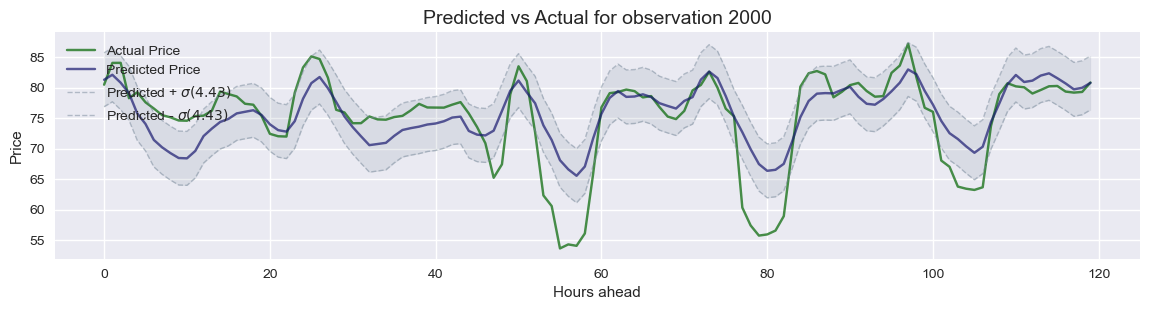

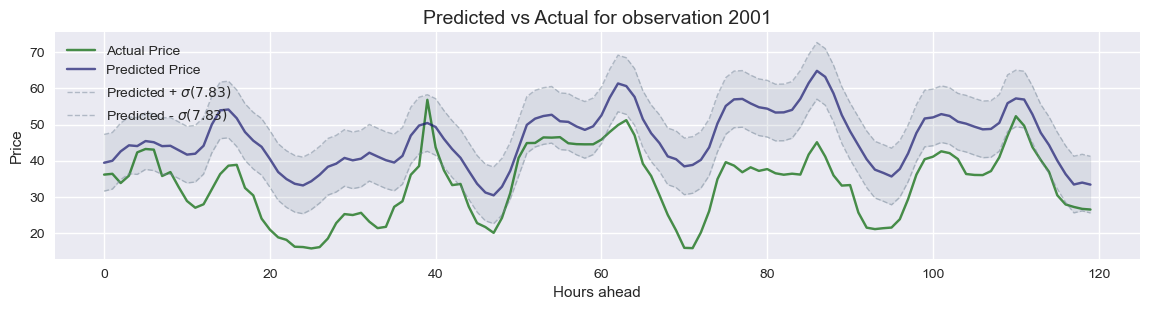

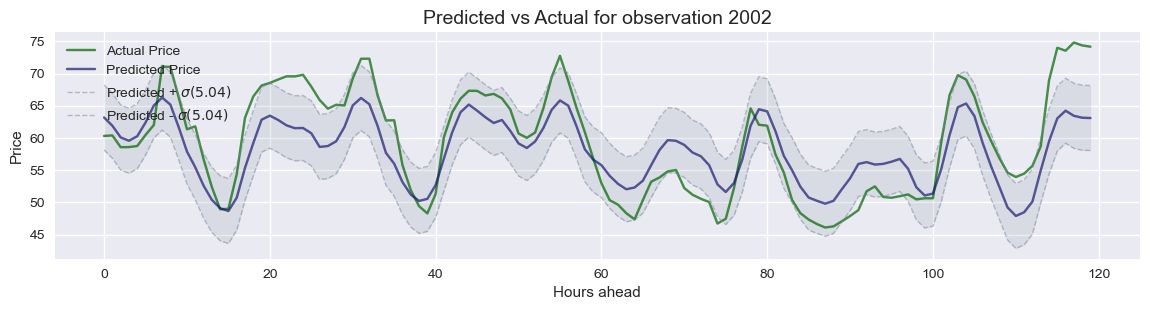

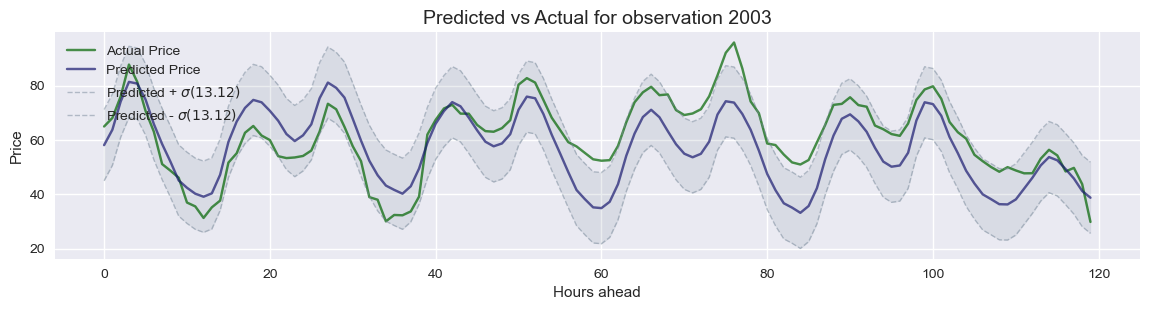

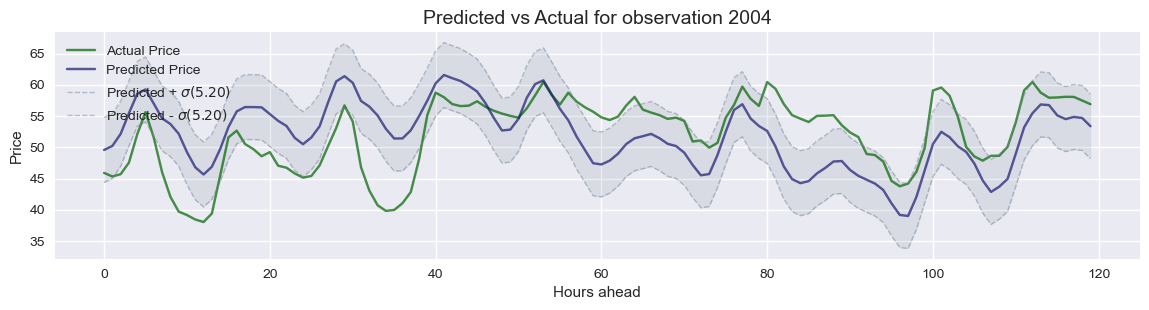

In [45]:
plot_actual_vs_prediction(price_prediction, price_target_test, variable_name = 'Price', start_inx = 2000, end_inx = 2005)

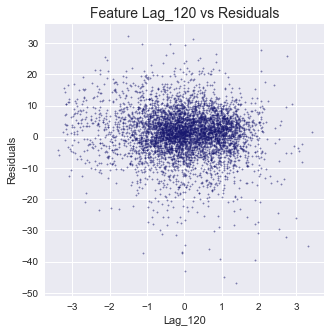

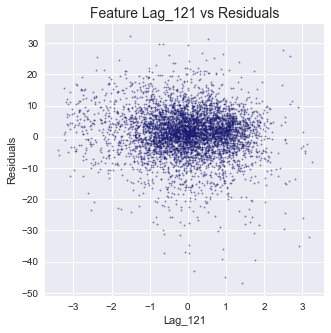

In [46]:
plot_feature_vs_residuals(price_atribute_test, price_attribute_col_names, 
                          price_prediction, price_target_test, start_index=200, stop_index=202, 
                          target_indx = 119, col_name = None) 

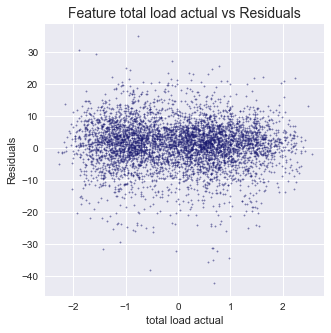

In [47]:
plot_feature_vs_residuals(price_atribute_test, price_attribute_col_names,  
                          price_prediction, price_target_test, start_index=155, stop_index=157, 
                          target_indx = 50, col_name = 'total load actual') 

### Multi-Output Linear Support Vector Regression - Accelerated Optimization

Хиперпараметрите  loss='squared_epsilon_insensitive' и dual=False ускоряват неимоверно много оптимизацията, без да повлияват особено на производителността.

__loss='squared_epsilon_insensitive'__<br>
Specifies the loss function. The epsilon-insensitive loss (standard SVR) is the L1 loss(lasso), while the squared epsilon-insensitive loss (‘squared_epsilon_insensitive’) is the L2 loss(ridge).


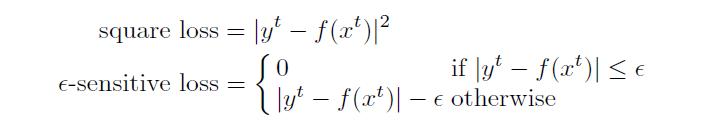

_Eпсилон-чувствителната (epsilon_insensitive) загуба се различава от квадратната загуба(squared_epsilon_insensitive) в две отношения:_<br>
_1. тя не наказва онези случаи, които са в e-tune, и_<br>
_2. случаите се наказват линейно пропорционално на това колко са далеч от правилния изход._<br>
_Следователно e-чувствителната загуба е по-толерантна към шумни случаи и следователно по-стабилна от квадратната загуба._<br>

__dual=False__ - Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features. <br>
_SVM се дефинира по два начина, единият е dual = True, а другият е първичната форма(dual=False). И двете получават еднакъв резултат от оптимизацията, но начинът, по който го получават, е много различен.  dual=False е предпочитан, когато не е необходимо да прилагаме трик на ядрото към данните и наборът от данни е голям, но размерът на всяка точка от данни е малък. dual=True е за предпочитане, когато данните имат огромно измерение и трябва да приложим трика на ядрото._


In [22]:
c = [0.0001, 0.0005, 0.001, 0.01,  0.1, 1, 10, 100] 
res_mo_svr = get_model_results(PC_train, price_target_train, PC_test, price_target_test, c, "MultiOutputRegressor")
res_mo_svr

Function took 621.8190 seconds


mse_train  mae_train  rmse_train  r2_train    mse_test  mae_test  \
C                                                                             
0.0001    124.521190   9.627240   11.157504  0.378157  125.007157  9.668629   
0.0005     56.327735   5.713693    7.500564  0.718716   56.299240  5.726822   
0.0010     53.598184   5.469661    7.316105  0.732347   53.492303  5.474634   
0.0100     52.662655   5.346778    7.251803  0.737019   52.484085  5.344413   
0.1000     52.653922   5.340217    7.251201  0.737063   52.467917  5.337162   
1.0000     52.653926   5.339622    7.251201  0.737063   52.467171  5.336500   
10.0000    52.653935   5.339563    7.251202  0.737063   52.467111  5.336434   
100.0000   52.653936   5.339556    7.251202  0.737063   52.467095  5.336426   

          rmse_test   r2_test  
C                              
0.0001    11.179069  0.357284  
0.0005     7.498970  0.710511  
0.0010     7.309290  0.724948  
0.0100     7.239991  0.730139  
0.1000     7.238881  0.730223  
1.0000     7.238830  0.730227  
10.0000    7.238826  0.730227  
100.0000   7.238825  0.730227

In [23]:
res_mo_svr.to_csv("data/result_MOWrapper_LinearSVR.csv")

## Linear Support Vector Regression with Regressor Chain

### Test Base Model

In [21]:
@timeit
def chain_linear_svr(att, target):
    svr = LinearSVR(C=0.01, max_iter = 1000, tol = 0.001, random_state=42)
    svr_wrapped = RegressorChain(svr)
    svr_wrapped.fit(att, target)            
    return svr_wrapped

price_chain_linear_SVR = chain_linear_svr(PC_train, price_target_train)

C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.p

C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.p

C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.p

C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.p

Function took 1921.9920 seconds


C:\Users\o.yordanova\anaconda3\envs\tfenv1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [22]:
save_model(price_chain_linear_SVR, "#price_svr_rchain_base_model.sav")

In [29]:
price_chain_linear_SVR = load_model("#price_svr_rchain_base_model.sav")

In [62]:
price_chain_linear_SVR

RegressorChain(base_estimator=LinearSVR(C=0.01, random_state=42, tol=0.001))

In [30]:
_, _, _ = evaluation_report(price_chain_linear_SVR, PC_train, price_target_train)

Score Results:
Mean squared error: 64.59
Root mean squared error: 8.00
Mean absolute error: 6.11
Coefficient of determination: 0.6775
Predicted mean: 56.629 (11.803)


In [31]:
_, _, _ = evaluation_report(price_chain_linear_SVR, PC_test, price_target_test)

Score Results:
Mean squared error: 64.41
Root mean squared error: 7.99
Mean absolute error: 6.11
Coefficient of determination: 0.6687
Predicted mean: 56.611 (11.713)


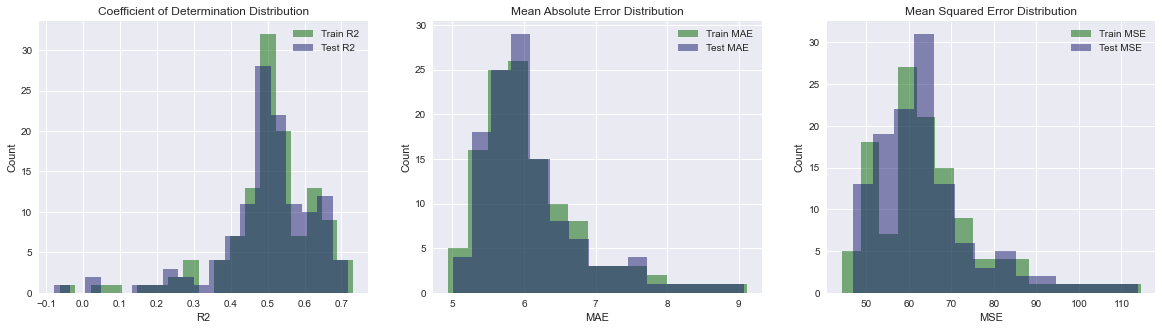

In [32]:
r2_train, r2_test, mae_train, mae_test, mse_train, mse_test = generate_score_distributions(price_chain_linear_SVR, PC_train, price_target_train, PC_test, price_target_test )

In [52]:
pv_r2_ttest = get_ttest_2samples(r2_train, r2_test)
pv_mae_ttest = get_ttest_2samples(mae_train, mae_test)
pv_mse_ttest = get_ttest_2samples(mse_train, mse_test)

p-value: 0.6636410762246778
fail to reject the null hypothesis
p-value: 0.9904592320968443
fail to reject the null hypothesis
p-value: 0.9083049560284268
fail to reject the null hypothesis


In [53]:
pv_r2_ztest = get_ztest_2samples(r2_train, r2_test)
pv_mae_ztest = get_ztest_2samples(mae_train, mae_test)
pv_mse_ztest = get_ztest_2samples(mse_train, mse_test)

p-value: 0.6632464472070134
fail to reject the null hypothesis
p-value: 0.9904492040876307
fail to reject the null hypothesis
p-value: 0.9082077377774385
fail to reject the null hypothesis


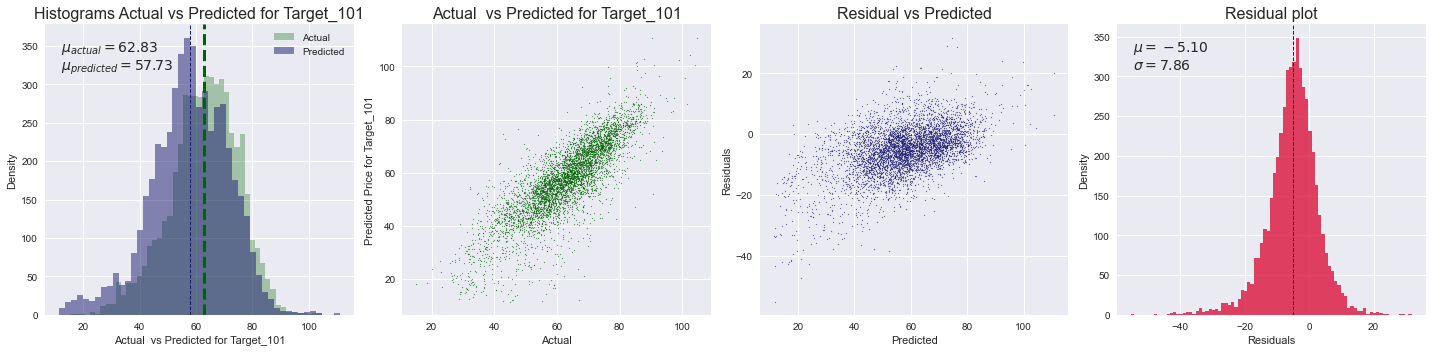

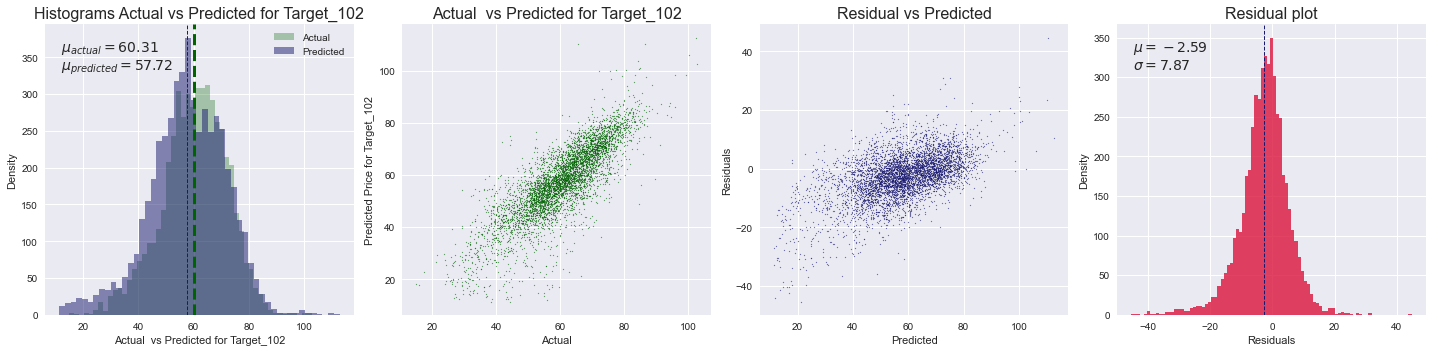

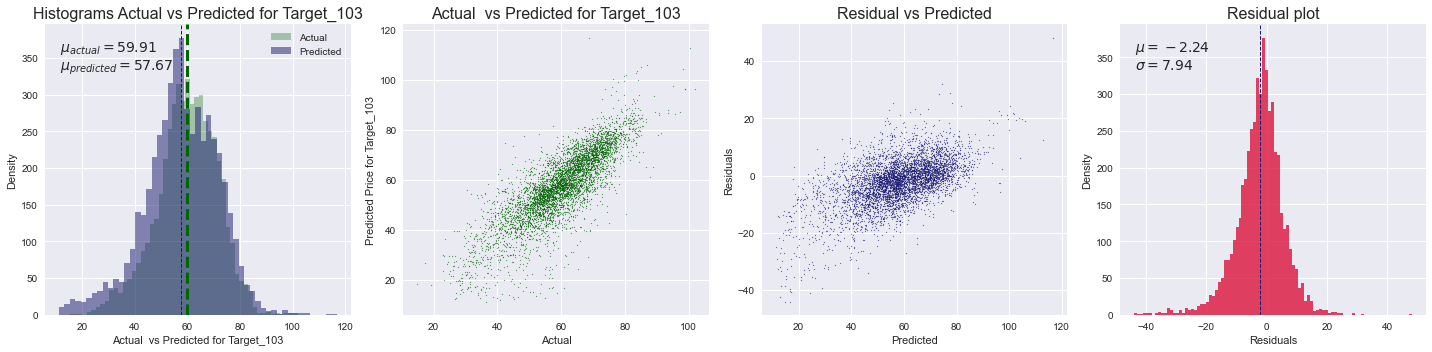

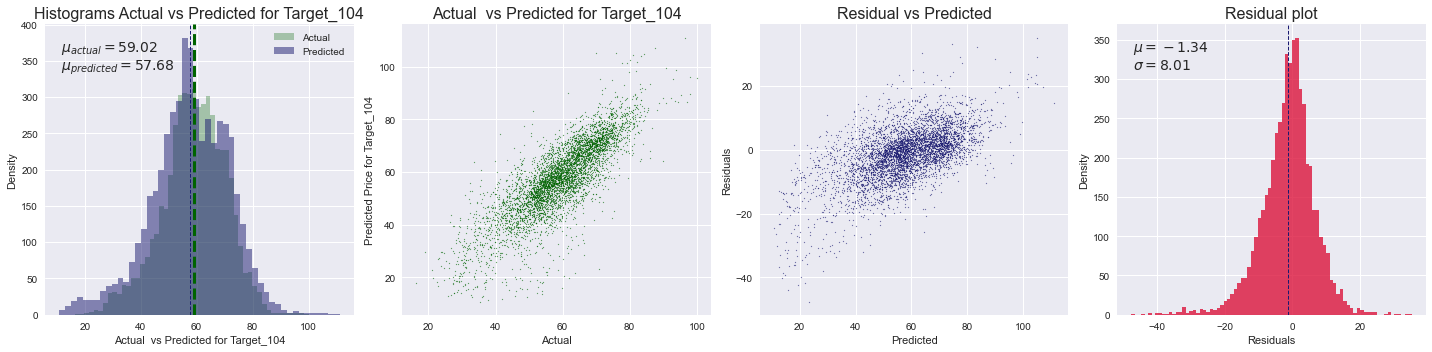

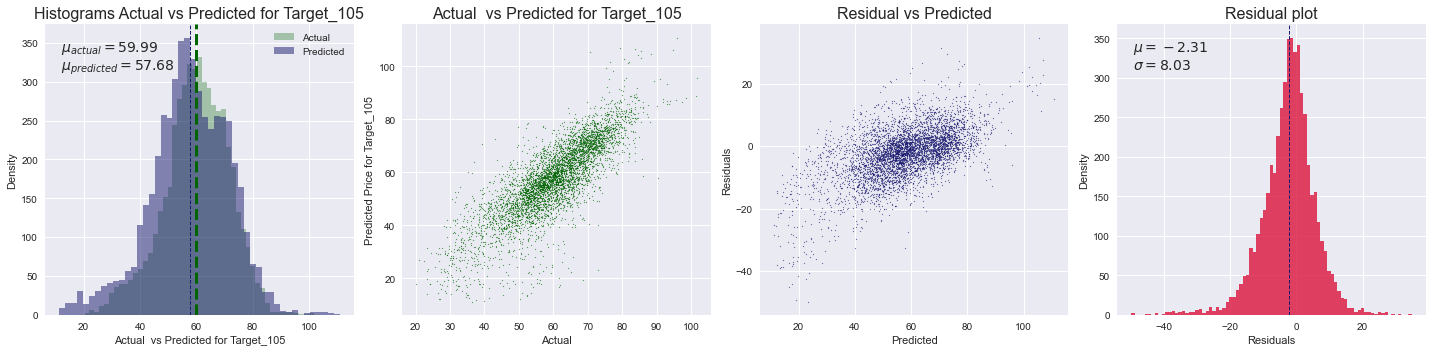

In [33]:
price_prediction = price_chain_linear_SVR.predict(PC_test)
e_minus_o = get_and_plot_data(price_prediction, price_target_test, start_index=100, stop_index=105)

In [60]:
print(get_ttest (price_prediction, price_target_test, idx=10))

p-value: 3.3141415766968386e-42
we are rejecting null hypothesis


In [61]:
print(get_ztest (price_prediction, price_target_test, idx=10))

p-value: 5.9782983772486375e-43
reject null hypothesis


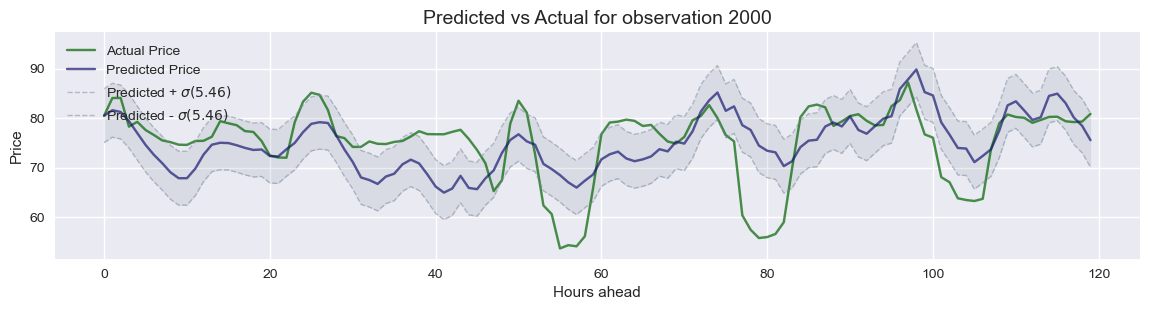

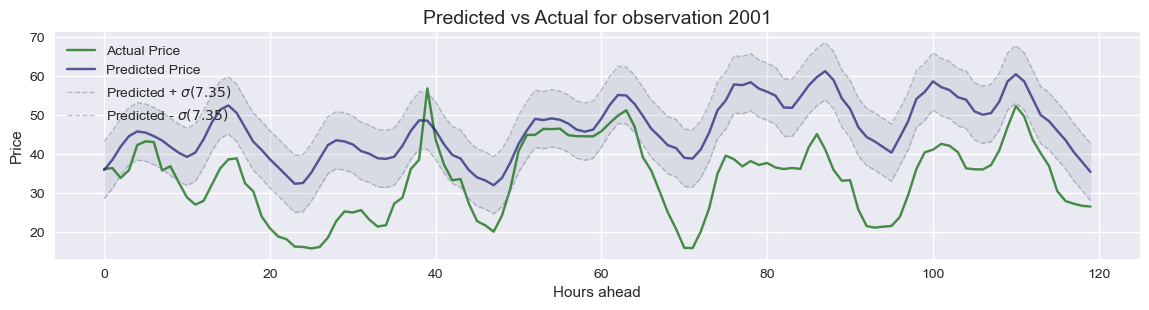

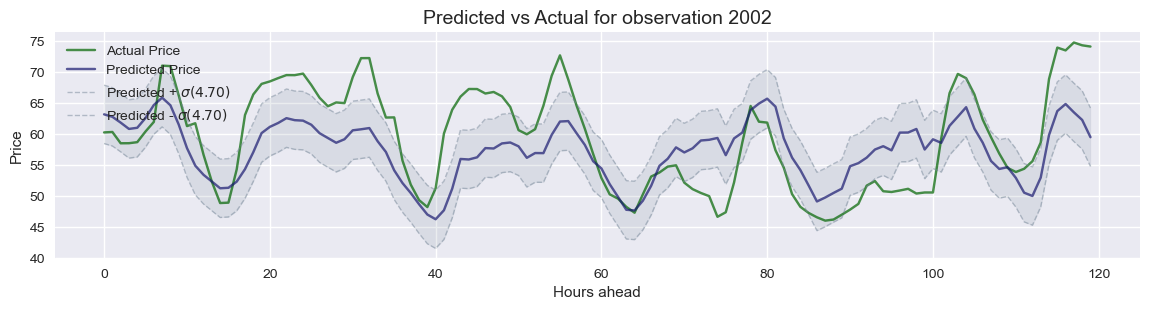

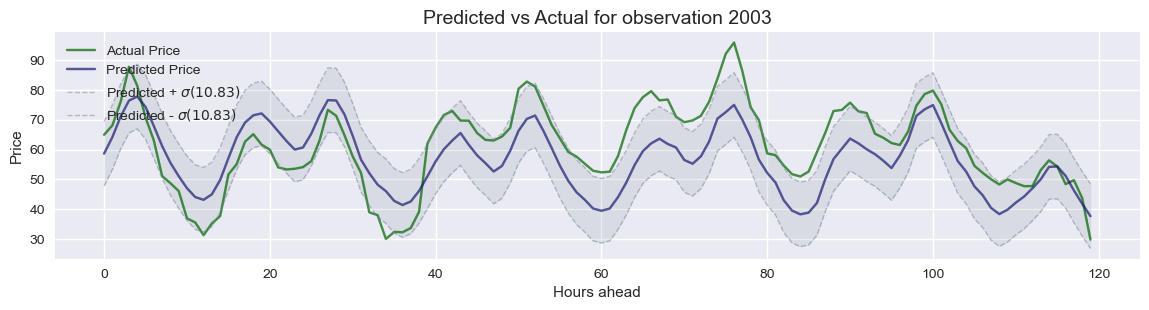

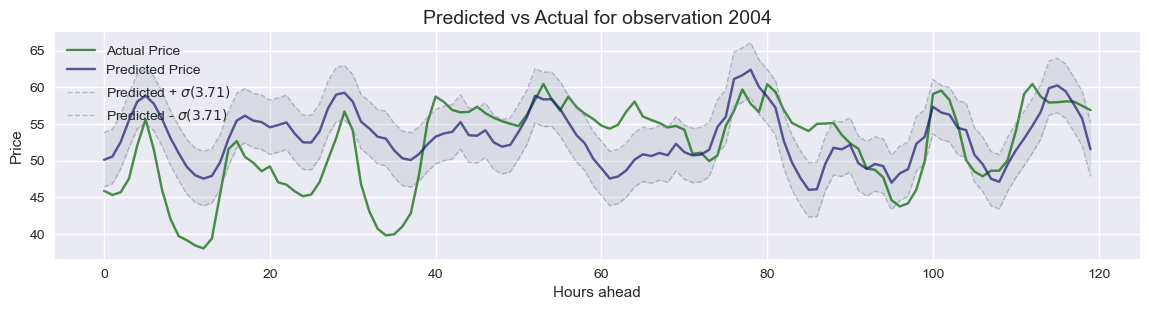

In [57]:
plot_actual_vs_prediction(price_prediction, price_target_test, variable_name = 'Price', start_inx = 2000, end_inx = 2005)

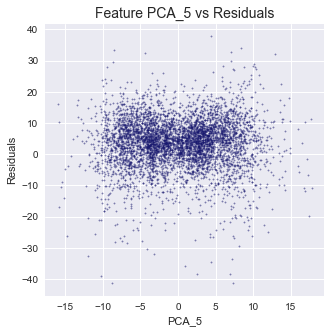

In [34]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=5, stop_index=6, target_indx = 119, col_name = None) 

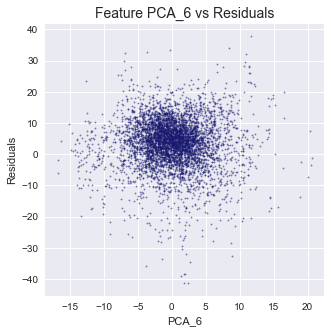

In [35]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=45, stop_index=52, target_indx = 119, col_name = 'PCA_6') 

### Regressor Chain Linear Support Vector Regression - Accelerated Optimization

In [67]:
c = [0.0001, 0.0005, 0.001, 0.01,  0.1, 1, 10, 100, 1000, 100000] 
res_rc_svr = get_model_results(PC_train, price_target_train, PC_test, price_target_test, c, "RegressorChain")
res_rc_svr

Function took 361.0401 seconds


mse_train  mae_train  rmse_train  r2_train    mse_test  \
C                                                                      
0.0001       149.987425  10.513870   12.236621  0.251005  149.395512   
0.0005        75.189569   6.707401    8.653415  0.624532   74.620309   
0.0010        71.303429   6.427890    8.426721  0.643937   70.741784   
0.0100        69.201910   6.247666    8.302496  0.654431   68.651601   
0.1000        69.139517   6.237261    8.298692  0.654741   68.586665   
1.0000        69.126711   6.235844    8.297939  0.654805   68.573929   
10.0000       69.071150   6.233144    8.294768  0.655083   68.523449   
100.0000      69.127724   6.235941    8.297997  0.654800   68.575001   
1000.0000     69.125758   6.235721    8.297882  0.654810   68.572985   
100000.0000   69.125759   6.235715    8.297882  0.654810   68.573067   

              mae_test  rmse_test   r2_test  
C                                            
0.0001       10.494865  12.212243  0.231489  
0.0005        6.680517   8.621743  0.616072  
0.0010        6.399891   8.394846  0.636047  
0.0100        6.219862   8.270949  0.646827  
0.1000        6.209526   8.266983  0.647164  
1.0000        6.208119   8.266231  0.647230  
10.0000       6.205555   8.263351  0.647490  
100.0000      6.208218   8.266294  0.647225  
1000.0000     6.207998   8.266174  0.647235  
100000.0000   6.207993   8.266179  0.647235

In [73]:
res_rc_svr.to_csv("data/result_RCWrapper_LinearSVR.csv")

In [12]:
@timeit
def chain_linear_svr(att, target):
    svr = LinearSVR(C=100, max_iter = 1000, tol = 0.001, random_state=42, loss='squared_epsilon_insensitive', dual=False)
    svr_wrapped = RegressorChain(svr)
    svr_wrapped.fit(att, target)            
    return svr_wrapped

price_chain_linear_SVR = chain_linear_svr(PC_train, price_target_train)

Function took 31.9725 seconds


In [13]:
save_model(price_chain_linear_SVR, "#price_svr_rchain_optimal_model.sav")

In [36]:
price_chain_linear_SVR = load_model("#price_svr_rchain_optimal_model.sav")

In [64]:
price_chain_linear_SVR

RegressorChain(base_estimator=LinearSVR(C=100, dual=False,
                                        loss='squared_epsilon_insensitive',
                                        random_state=42, tol=0.001))

In [37]:
_, _, _ = evaluation_report(price_chain_linear_SVR, PC_train, price_target_train)

Score Results:
Mean squared error: 69.13
Root mean squared error: 8.30
Mean absolute error: 6.24
Coefficient of determination: 0.6548
Predicted mean: 57.018 (11.896)


In [38]:
_, _, _ = evaluation_report(price_chain_linear_SVR, PC_test, price_target_test)

Score Results:
Mean squared error: 68.58
Root mean squared error: 8.27
Mean absolute error: 6.21
Coefficient of determination: 0.6472
Predicted mean: 57.025 (11.831)


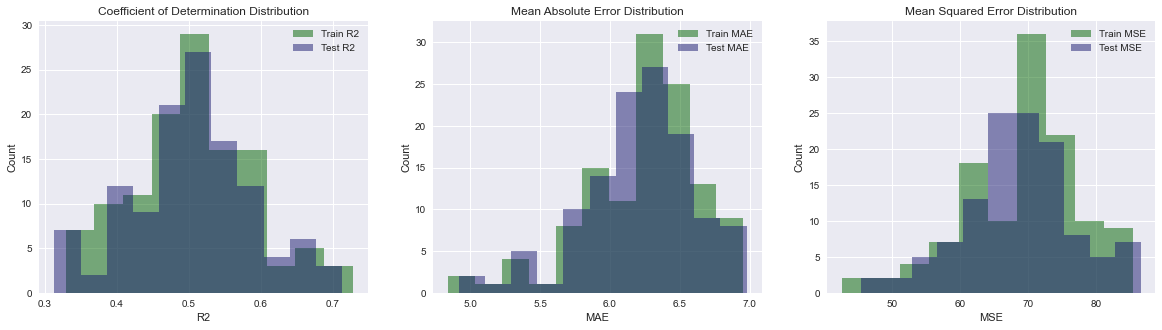

In [39]:
r2_train, r2_test, mae_train, mae_test, mse_train, mse_test = generate_score_distributions(price_chain_linear_SVR, PC_train, price_target_train, PC_test, price_target_test )

In [68]:
pv_r2_ttest = get_ttest_2samples(r2_train, r2_test)
pv_mae_ttest = get_ttest_2samples(mae_train, mae_test)
pv_mse_ttest = get_ttest_2samples(mse_train, mse_test)

p-value: 0.875398532476631
fail to reject the null hypothesis
p-value: 0.5977412617116686
fail to reject the null hypothesis
p-value: 0.6060367195744032
fail to reject the null hypothesis


In [69]:
pv_r2_ztest = get_ztest_2samples(r2_train, r2_test)
pv_mae_ztest = get_ztest_2samples(mae_train, mae_test)
pv_mse_ztest = get_ztest_2samples(mse_train, mse_test)

p-value: 0.8752654508481399
fail to reject the null hypothesis
p-value: 0.5972489394114717
fail to reject the null hypothesis
p-value: 0.6055572255290382
fail to reject the null hypothesis


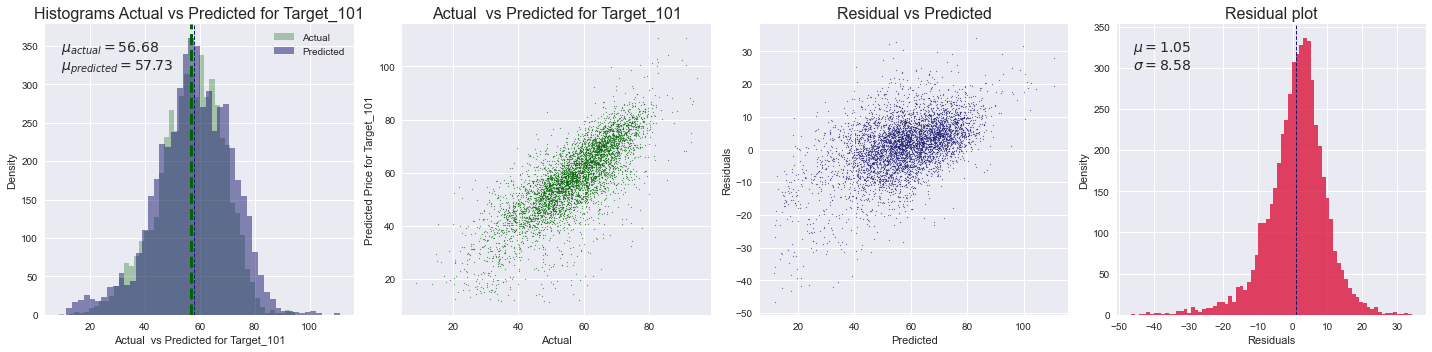

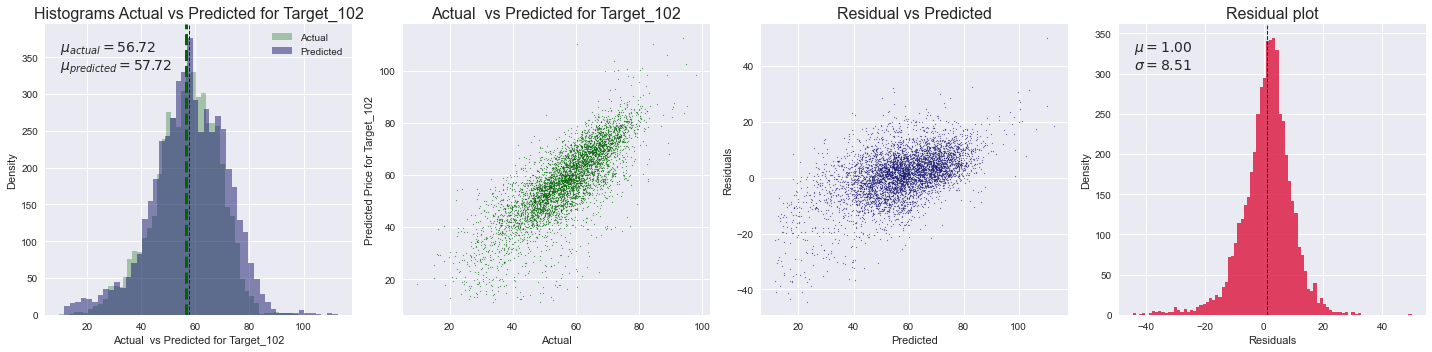

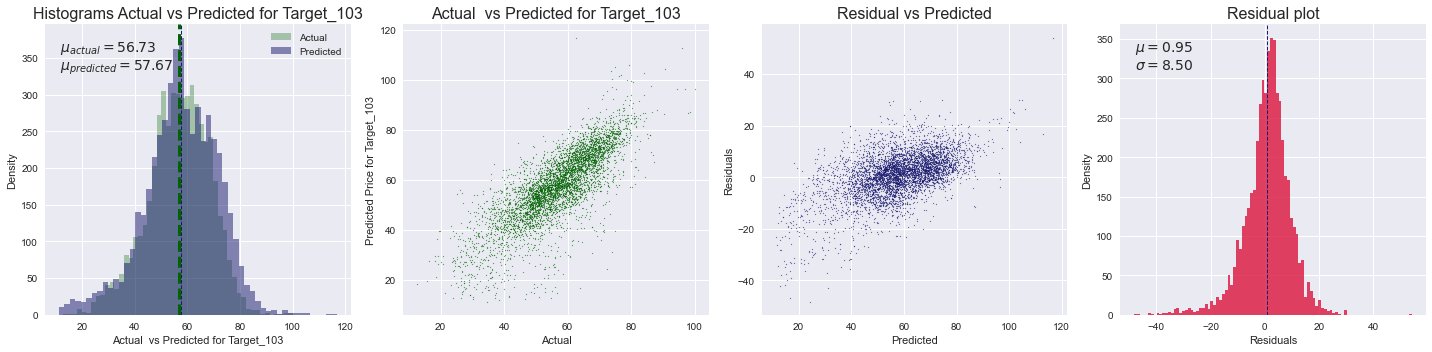

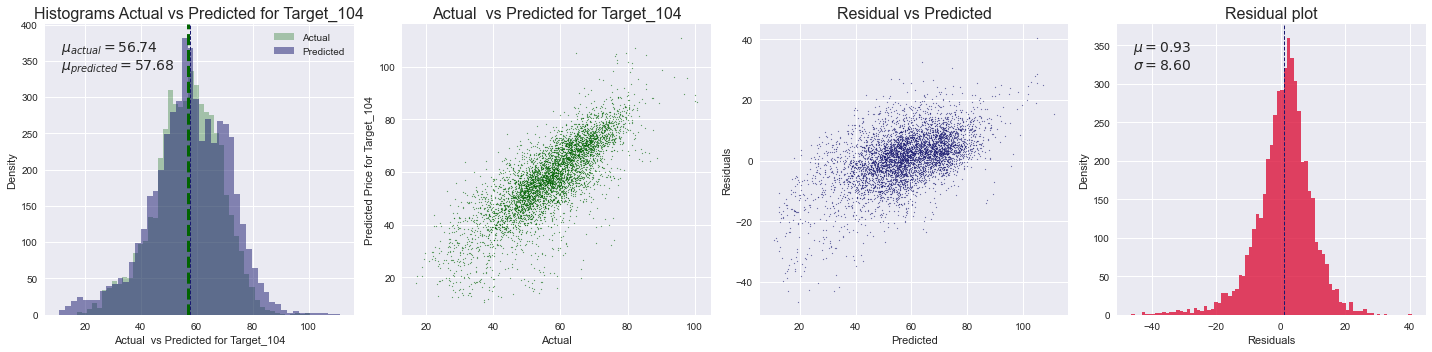

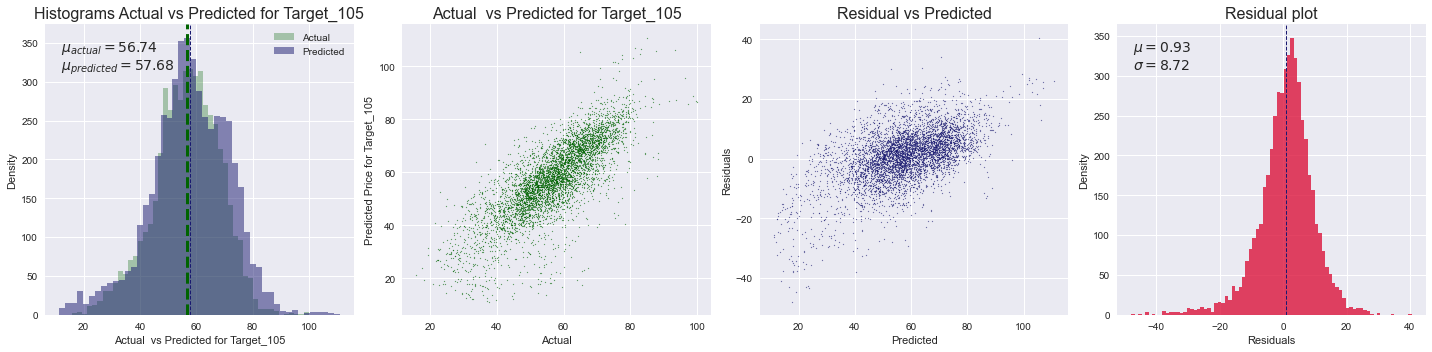

In [40]:
price_prediction = price_chain_linear_SVR.predict(PC_test)
e_minus_o = get_and_plot_data(price_prediction, price_target_test, start_index=100, stop_index=105)

In [73]:
print(get_ttest (price_prediction, price_target_test, idx=10))

p-value: 0.1115843819397068
we are accepting null hypothesis


In [74]:
print(get_ztest (price_prediction, price_target_test, idx=10))

p-value: 0.11152276752589708
accept null hypothesis


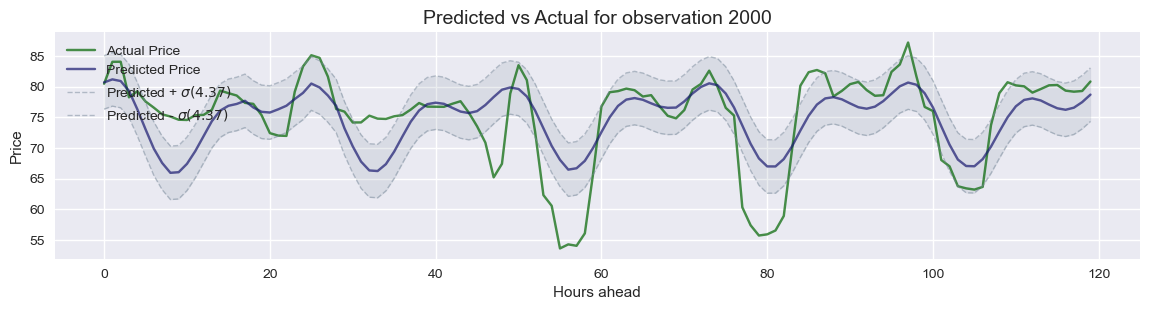

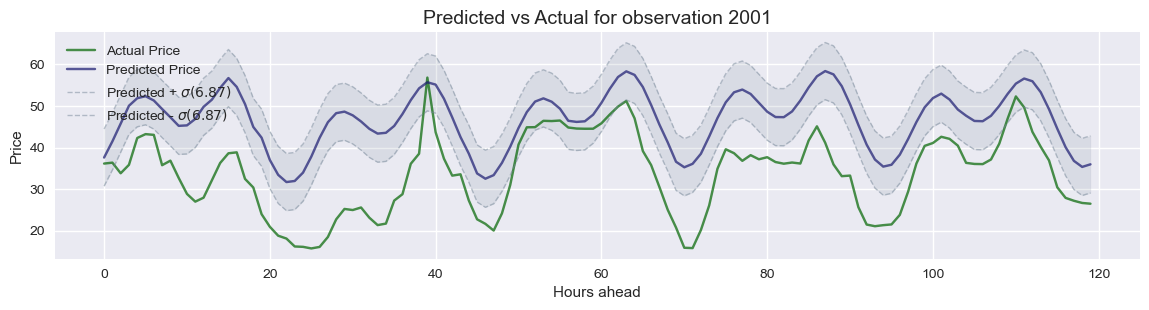

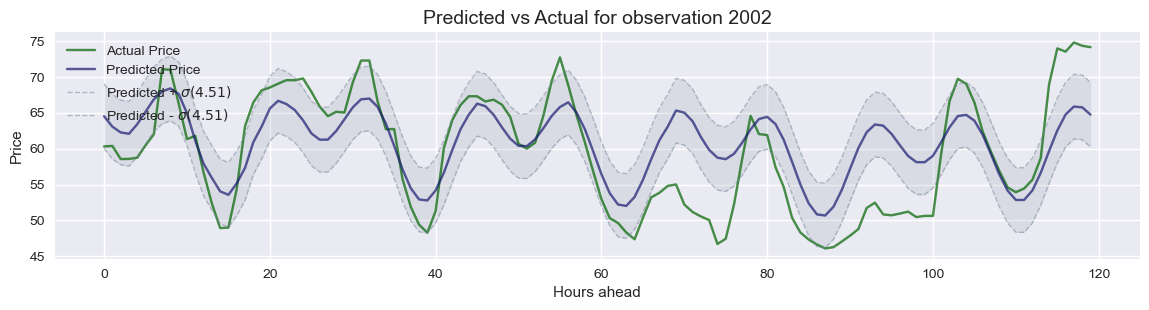

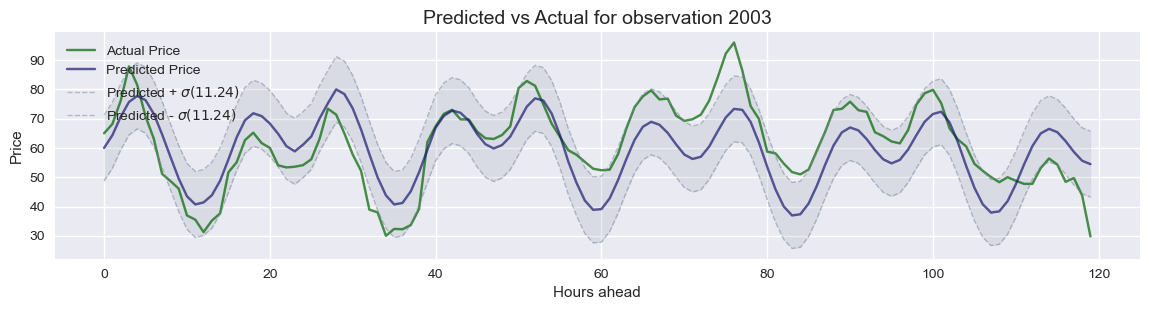

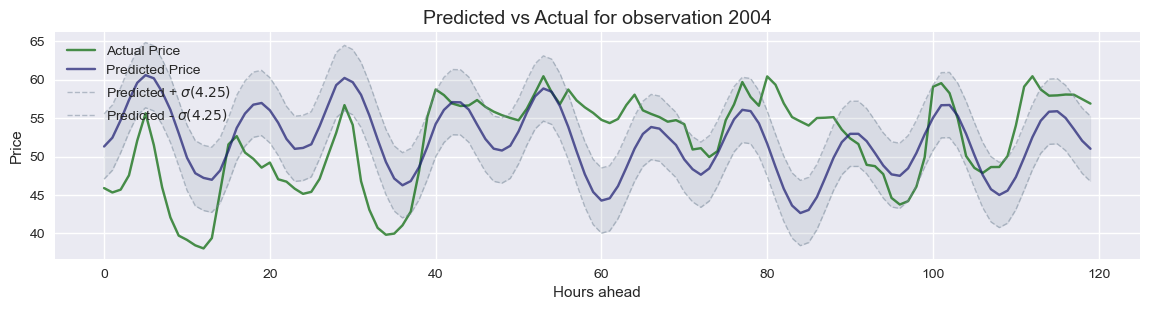

In [75]:
plot_actual_vs_prediction(price_prediction, price_target_test, variable_name = 'Price', start_inx = 2000, end_inx = 2005)

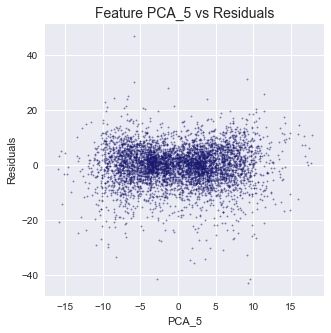

In [45]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=5, stop_index=6, target_indx = 1, col_name = None) 

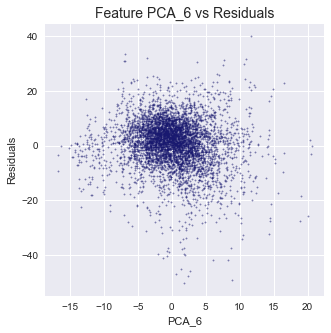

In [46]:
plot_feature_vs_residuals_PCA(PC_test, price_prediction, price_target_test, 
                              start_index=45, stop_index=52, target_indx = 119, col_name = 'PCA_6') 

In [43]:
pd.DataFrame(PC_test).iloc[:, 6].min(), pd.DataFrame(PC_test).iloc[:, 6].max()

(-16.783329482544623, 20.59297149092086)